In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [2]:
# === CARGA DE DATOS ===
def load_education_data():
    """Carga solo los datasets educativos necesarios"""
    data = {}

    files = {
        'education': '../downloads/normalizacion/education.csv',
        'admissions': '../downloads/normalizacion/education_admition.csv',
        'enrollment': '../downloads/normalizacion/education_enrollment.csv',
        'edu_municipality': '../downloads/normalizacion/education_municipality.csv',
        'municipality': '../downloads/normalizacion/municipality.csv'
    }

    for name, path in files.items():
        delimiter = ';' if 'education' in path and 'municipality' not in path else ','
        data[name] = pd.read_csv(path, delimiter=delimiter)
        if 'id' in data[name].columns:
            data[name]['id'] = data[name]['id'].astype(str)
        if 'id_education' in data[name].columns:
            data[name]['id_education'] = data[name]['id_education'].astype(str)
        if 'id_municipality' in data[name].columns:
            data[name]['id_municipality'] = data[name]['id_municipality'].astype(str)

    return data

data = load_education_data()


In [3]:
# === CONFIGURACIÓN DE CICLOS EDUCATIVOS ===
def get_cycle_config():
    """Configuración de ciclos con años de permanencia"""
    return {
        'infantil_i_ciclo': {
            'name': 'Infantil I',
            'años_permanencia': 3
        },
        'infantil_ii_ciclo': {
            'name': 'Infantil II',
            'años_permanencia': 3
        },
        'primaria': {
            'name': 'Primaria',
            'años_permanencia': 6
        },
        'eso': {
            'name': 'ESO',
            'años_permanencia': 4
        }
    }

cycle_config = get_cycle_config()


In [4]:
# === ANÁLISIS DE OCUPACIÓN POR CENTRO EDUCATIVO ===
def analyze_center_occupancy(data, cycle_config):
    """Analiza ocupación de centros: solicitudes vs capacidad estimada"""

    target_year = "2022-2023"
    valid_cycles = ['infantil_i_ciclo', 'infantil_ii_ciclo', 'primaria', 'eso']

    admissions = data['admissions'].copy()
    admissions = admissions[admissions['cycle'].isin(valid_cycles)]

    enrollment = data['enrollment'].copy()
    enrollment = enrollment[enrollment['cycle'].isin(valid_cycles)]

    centros_con_ciclos_validos = set()
    centros_enrollment = enrollment['id_education'].unique()
    centros_con_ciclos_validos.update(centros_enrollment)
    centros_admissions = admissions['id_education'].unique()
    centros_con_ciclos_validos.update(centros_admissions)

    center_analysis = []

    for center_id in centros_con_ciclos_validos:
        center_info = data['education'][data['education']['id'] == center_id]
        if center_info.empty:
            continue

        center_info = center_info.iloc[0]
        center_data = {
            'id_education': center_id,
            'center_name': center_info['name_short'],
            'center_type': center_info.get('description_short', 'No especificado')
        }

        total_plazas_estimadas = 0
        total_max_matriculados = 0
        total_matriculados_año_objetivo = 0
        total_solicitudes_presentadas = 0
        total_solicitudes_admitidas = 0
        ciclos_activos = 0

        for cycle in valid_cycles:
            config = cycle_config[cycle]

            cycle_enrollment_all_years = enrollment[
                (enrollment['id_education'] == center_id) &
                (enrollment['cycle'] == cycle)
            ]

            cycle_admissions_all_years = admissions[
                (admissions['id_education'] == center_id) &
                (admissions['cycle'] == cycle) &
                (admissions['type_solicitude'] == 'Admitidas')
            ]

            plazas_por_año = {}
            años_matricula = set(cycle_enrollment_all_years['year'].unique())
            años_admisiones = set(cycle_admissions_all_years['year'].unique())
            todos_los_años = años_matricula | años_admisiones

            for año in todos_los_años:
                matriculados_año = cycle_enrollment_all_years[
                    cycle_enrollment_all_years['year'] == año
                ]['total'].sum()

                admitidos_año = cycle_admissions_all_years[
                    cycle_admissions_all_years['year'] == año
                ]['total'].sum()

                if matriculados_año > 0 or admitidos_año > 0:
                    plazas_año = matriculados_año / config['años_permanencia']
                    plazas_por_año[año] = {
                        'matriculados': matriculados_año,
                        'admitidos': admitidos_año,
                        'total_estudiantes': matriculados_año,
                        'plazas_estimadas': plazas_año
                    }

            if plazas_por_año:
                año_max_plazas = max(plazas_por_año.keys(), key=lambda x: plazas_por_año[x]['plazas_estimadas'])
                max_plazas_data = plazas_por_año[año_max_plazas]

                plazas_estimadas = max_plazas_data['plazas_estimadas']
                max_matriculados = max_plazas_data['matriculados']
                max_admitidos = max_plazas_data['admitidos']
                max_total_estudiantes = max_plazas_data['total_estudiantes']
                año_max = año_max_plazas
            else:
                plazas_estimadas = 0
                max_matriculados = 0
                max_admitidos = 0
                max_total_estudiantes = 0
                año_max = 'N/A'

            cycle_enrollment_target = enrollment[
                (enrollment['id_education'] == center_id) &
                (enrollment['cycle'] == cycle) &
                (enrollment['year'] == target_year)
            ]
            matriculados_año_objetivo = cycle_enrollment_target['total'].sum()

            cycle_admissions_target = admissions[
                (admissions['id_education'] == center_id) &
                (admissions['cycle'] == cycle) &
                (admissions['year'] == target_year)
            ]

            solicitudes_presentadas = cycle_admissions_target[
                cycle_admissions_target['type_solicitude'] == 'Presentadas'
            ]['total'].sum()
            solicitudes_admitidas = cycle_admissions_target[
                cycle_admissions_target['type_solicitude'] == 'Admitidas'
            ]['total'].sum()

            if cycle == 'primaria':
                infantil_ii_enrollment_all = enrollment[
                    (enrollment['id_education'] == center_id) &
                    (enrollment['cycle'] == 'infantil_ii_ciclo')
                ]

                infantil_ii_admissions_all = admissions[
                    (admissions['id_education'] == center_id) &
                    (admissions['cycle'] == 'infantil_ii_ciclo') &
                    (admissions['type_solicitude'] == 'Admitidas')
                ]

                if not infantil_ii_enrollment_all.empty or not infantil_ii_admissions_all.empty:
                    plazas_infantil_por_año = {}
                    años_inf_matricula = set(infantil_ii_enrollment_all['year'].unique())
                    años_inf_admisiones = set(infantil_ii_admissions_all['year'].unique())
                    todos_años_inf = años_inf_matricula | años_inf_admisiones

                    for año in todos_años_inf:
                        mat_inf = infantil_ii_enrollment_all[
                            infantil_ii_enrollment_all['year'] == año
                        ]['total'].sum()

                        if mat_inf > 0:
                            plazas_inf_año = (mat_inf) / cycle_config['infantil_ii_ciclo']['años_permanencia']
                            plazas_infantil_por_año[año] = plazas_inf_año

                    if plazas_infantil_por_año:
                        if target_year in plazas_infantil_por_año:
                            transiciones_automaticas = plazas_infantil_por_año[target_year]
                        else:
                            transiciones_automaticas = 0

                        max_plazas_infantil = max(plazas_infantil_por_año.values())
                    else:
                        transiciones_automaticas = 0

                    solicitudes_admitidas_corregidas = solicitudes_admitidas + transiciones_automaticas
                    center_data[f'{cycle}_transiciones_infantil'] = transiciones_automaticas
                    center_data[f'{cycle}_max_plazas_infantil_ii'] = max_plazas_infantil if plazas_infantil_por_año else 0
                else:
                    solicitudes_admitidas_corregidas = solicitudes_admitidas
                    center_data[f'{cycle}_transiciones_infantil'] = 0
                    center_data[f'{cycle}_max_plazas_infantil_ii'] = 0
            else:
                solicitudes_admitidas_corregidas = solicitudes_admitidas
                center_data[f'{cycle}_transiciones_infantil'] = 0

            tasa_ocupacion_ciclo = (matriculados_año_objetivo / max_matriculados) if max_matriculados > 0 else 0
            ratio_demanda_ciclo = (solicitudes_presentadas / plazas_estimadas) if plazas_estimadas > 0 else 0
            ratio_admision_vs_capacidad = (solicitudes_admitidas_corregidas / plazas_estimadas) if plazas_estimadas > 0 else 0
            eficiencia_admision = (solicitudes_admitidas / solicitudes_presentadas) if solicitudes_presentadas > 0 else 0

            center_data.update({
                f'{cycle}_max_matriculados': max_matriculados,
                f'{cycle}_max_admitidos': max_admitidos,
                f'{cycle}_max_total_estudiantes': max_total_estudiantes,
                f'{cycle}_año_max': año_max,
                f'{cycle}_matriculados_objetivo': matriculados_año_objetivo,
                f'{cycle}_plazas_estimadas': plazas_estimadas,
                f'{cycle}_solicitudes_presentadas': solicitudes_presentadas,
                f'{cycle}_solicitudes_admitidas': solicitudes_admitidas,
                f'{cycle}_solicitudes_admitidas_corregidas': solicitudes_admitidas_corregidas,
                f'{cycle}_tasa_ocupacion': tasa_ocupacion_ciclo,
                f'{cycle}_ratio_demanda': ratio_demanda_ciclo,
                f'{cycle}_ratio_admision_capacidad': ratio_admision_vs_capacidad,
                f'{cycle}_eficiencia_admision': eficiencia_admision,
                f'{cycle}_activo': 1 if plazas_estimadas > 0 or solicitudes_presentadas > 0 else 0
            })

            if plazas_estimadas > 0 or solicitudes_presentadas > 0:
                ciclos_activos += 1
                total_plazas_estimadas += plazas_estimadas
                total_max_matriculados += max_matriculados
                total_matriculados_año_objetivo += matriculados_año_objetivo
                total_solicitudes_presentadas += solicitudes_presentadas
                total_solicitudes_admitidas += solicitudes_admitidas_corregidas

        if ciclos_activos > 0:
            total_solicitudes_admitidas_reales = 0
            for cycle in valid_cycles:
                if center_data.get(f'{cycle}_activo', 0) == 1:
                    total_solicitudes_admitidas_reales += center_data[f'{cycle}_solicitudes_admitidas']

            center_data.update({
                'ciclos_activos': ciclos_activos,
                'total_plazas_estimadas': total_plazas_estimadas,
                'total_matriculados': total_matriculados_año_objetivo,
                'total_max_matriculados': total_max_matriculados,
                'total_solicitudes_presentadas': total_solicitudes_presentadas,
                'total_solicitudes_admitidas': total_solicitudes_admitidas,
                'total_solicitudes_admitidas_reales': total_solicitudes_admitidas_reales,
                'tasa_ocupacion_centro': (total_matriculados_año_objetivo / total_max_matriculados) if total_max_matriculados > 0 else 0,
                'ratio_demanda_centro': (total_solicitudes_presentadas / total_plazas_estimadas) if total_plazas_estimadas > 0 else 0,
                'ratio_admision_capacidad_centro': (total_solicitudes_admitidas / total_plazas_estimadas) if total_plazas_estimadas > 0 else 0,
                'eficiencia_admision_centro': (total_solicitudes_admitidas_reales / total_solicitudes_presentadas) if total_solicitudes_presentadas > 0 else 0
            })

            center_analysis.append(center_data)

    return pd.DataFrame(center_analysis)

centers_df = analyze_center_occupancy(data, cycle_config)
centers_activos = centers_df[centers_df['ciclos_activos'] > 0]


In [5]:
# === ANÁLISIS DE COBERTURA EDUCATIVA POR MUNICIPIO ===
def load_demographic_data():
    """Carga datos demográficos para el análisis de cobertura"""
    demographics = pd.read_csv('../downloads/normalizacion/municipality_demographics.csv')

    age_to_cycle_mapping = {
        '0-4': ['infantil_i_ciclo', 'infantil_ii_ciclo'],
        '5-9': ['infantil_ii_ciclo', 'primaria'],
        '10-14': ['primaria', 'eso'],
        '15-19': ['eso']
    }

    return demographics, age_to_cycle_mapping

def analyze_municipal_coverage(data, centers_df, cycle_config):
    """Analiza la cobertura educativa por municipio"""

    demographics, age_mapping = load_demographic_data()
    edu_municipality = data['edu_municipality']
    municipalities = data['municipality']

    latest_year = demographics['year'].max()
    demographics_latest = demographics[demographics['year'] == latest_year].copy()

    municipal_analysis = []
    municipios_con_centros = edu_municipality['id_municipality'].unique()

    for municipality_id in municipios_con_centros:
        muni_info = municipalities[municipalities['id'] == municipality_id]
        if muni_info.empty:
            continue

        muni_info = muni_info.iloc[0]
        muni_secondary_id = muni_info['id_secondary']

        muni_demographics = demographics_latest[
            demographics_latest['id_secondary_municipality'] == muni_secondary_id
        ].copy()

        if muni_demographics.empty:
            continue

        centros_municipio = edu_municipality[
            edu_municipality['id_municipality'] == municipality_id
        ]['id_education'].unique()

        centros_activos_municipio = centers_df[
            centers_df['id_education'].isin(centros_municipio)
        ].copy()

        if centros_activos_municipio.empty:
            continue

        municipal_data = {
            'id_municipality': municipality_id,
            'municipality_name': muni_info['name'],
            'total_centers': len(centros_activos_municipio),
            'total_population_0_19': 0
        }

        for _, demo_row in muni_demographics.iterrows():
            age_range = demo_row['range']
            population = demo_row['total']

            if age_range in ['0-4', '5-9', '10-14', '15-19']:
                municipal_data['total_population_0_19'] += population
                municipal_data[f'population_{age_range}'] = population

        for cycle in ['infantil_i_ciclo', 'infantil_ii_ciclo', 'primaria', 'eso']:
            config = cycle_config[cycle]

            cycle_max_matriculados = centros_activos_municipio[f'{cycle}_max_matriculados'].sum()
            cycle_plazas_estimadas = centros_activos_municipio[f'{cycle}_plazas_estimadas'].sum()
            cycle_solicitudes = centros_activos_municipio[f'{cycle}_solicitudes_presentadas'].sum()
            cycle_admitidos = centros_activos_municipio[f'{cycle}_solicitudes_admitidas_corregidas'].sum()

            centros_con_ciclo = centros_activos_municipio[
                centros_activos_municipio[f'{cycle}_activo'] == 1
            ]
            num_centros_ciclo = len(centros_con_ciclo)

            municipal_data.update({
                f'{cycle}_capacity': cycle_max_matriculados,
                f'{cycle}_plazas_estimadas': cycle_plazas_estimadas,
                f'{cycle}_max_matriculados': cycle_max_matriculados,
                f'{cycle}_solicitudes': cycle_solicitudes,
                f'{cycle}_admitidos': cycle_admitidos,
                f'{cycle}_num_centers': num_centros_ciclo,
                f'{cycle}_centers_names': ', '.join(centros_con_ciclo['center_name'].tolist()) if num_centros_ciclo > 0 else 'Ninguno'
            })

        pop_0_4 = municipal_data.get('population_0-4', 0)
        estimated_need_infantil_i = (pop_0_4 * 3) / 5

        pop_5_9 = municipal_data.get('population_5-9', 0)
        estimated_need_infantil_ii = (pop_0_4 * 2) / 5 + (pop_5_9 * 1) / 5

        pop_10_14 = municipal_data.get('population_10-14', 0)
        estimated_need_primaria = (pop_5_9 * 4) / 5 + (pop_10_14 * 2) / 5

        pop_15_19 = municipal_data.get('population_15-19', 0)
        estimated_need_eso = (pop_10_14 * 3) / 5 + (pop_15_19 * 1) / 5

        needs = {
            'infantil_i_ciclo': estimated_need_infantil_i,
            'infantil_ii_ciclo': estimated_need_infantil_ii,
            'primaria': estimated_need_primaria,
            'eso': estimated_need_eso
        }

        total_estimated_need = 0
        total_capacity = 0
        cycles_with_need = 0
        cycles_covered = 0

        for cycle, estimated_need in needs.items():
            capacity = municipal_data[f'{cycle}_capacity']

            coverage_ratio = (capacity / estimated_need) if estimated_need > 0 else float('inf') if capacity > 0 else 0
            is_covered = coverage_ratio >= 1 if estimated_need > 0 else capacity > 0

            municipal_data.update({
                f'{cycle}_estimated_need': estimated_need,
                f'{cycle}_coverage_ratio': coverage_ratio,
                f'{cycle}_is_covered': is_covered,
                f'{cycle}_deficit': max(0, estimated_need - capacity)
            })

            if estimated_need > 0:
                cycles_with_need += 1
                total_estimated_need += estimated_need
                total_capacity += capacity
                if is_covered:
                    cycles_covered += 1

        overall_coverage_ratio = (total_capacity / total_estimated_need) if total_estimated_need > 0 else 0
        coverage_percentage = (cycles_covered / cycles_with_need * 100) if cycles_with_need > 0 else 0

        cycles_with_access = 0
        cycles_available = ['infantil_i_ciclo', 'infantil_ii_ciclo', 'primaria', 'eso']

        for cycle in cycles_available:
            if municipal_data[f'{cycle}_num_centers'] > 0:
                cycles_with_access += 1

        access_percentage = (cycles_with_access / len(cycles_available)) * 100

        if cycles_with_access == len(cycles_available):
            access_classification = "Acceso Completo"
        elif cycles_with_access >= 3:
            access_classification = "Acceso Bueno"
        elif cycles_with_access >= 2:
            access_classification = "Acceso Parcial"
        elif cycles_with_access >= 1:
            access_classification = "Acceso Limitado"
        else:
            access_classification = "Sin Acceso"

        has_basic_education = (
            municipal_data['infantil_ii_ciclo_num_centers'] > 0 and
            municipal_data['primaria_num_centers'] > 0 and
            municipal_data['eso_num_centers'] > 0
        )

        has_mandatory_education = (
            municipal_data['primaria_num_centers'] > 0 and
            municipal_data['eso_num_centers'] > 0
        )

        municipal_data.update({
            'total_estimated_need': total_estimated_need,
            'total_capacity': total_capacity,
            'overall_coverage_ratio': overall_coverage_ratio,
            'cycles_with_need': cycles_with_need,
            'cycles_covered': cycles_covered,
            'coverage_percentage': coverage_percentage,
            'is_fully_covered': cycles_covered == cycles_with_need and cycles_with_need > 0,
            'total_deficit': max(0, total_estimated_need - total_capacity),
            'cycles_with_access': cycles_with_access,
            'access_percentage': access_percentage,
            'access_classification': access_classification,
            'has_basic_education': has_basic_education,
            'has_mandatory_education': has_mandatory_education,
            'missing_cycles': [cycle for cycle in cycles_available if municipal_data[f'{cycle}_num_centers'] == 0]
        })

        municipal_analysis.append(municipal_data)

    return pd.DataFrame(municipal_analysis)

municipal_coverage_df = analyze_municipal_coverage(data, centers_df, cycle_config)


In [6]:
# === IMPRIMIR COLUMNAS DE LOS DATAFRAMES PARA DOCUMENTACIÓN ===

print("="*80)
print("📊 COLUMNAS DEL DATAFRAME: centers_df")
print("="*80)
print(f"Total de columnas: {len(centers_df.columns)}")
print("\nListado de columnas:")
for i, col in enumerate(centers_df.columns, 1):
    print(f"{i:2d}. {col}")

print("\n" + "="*80)
print("🏛️ COLUMNAS DEL DATAFRAME: municipal_coverage_df")
print("="*80)
print(f"Total de columnas: {len(municipal_coverage_df.columns)}")
print("\nListado de columnas:")
for i, col in enumerate(municipal_coverage_df.columns, 1):
    print(f"{i:2d}. {col}")


📊 COLUMNAS DEL DATAFRAME: centers_df
Total de columnas: 75

Listado de columnas:
 1. id_education
 2. center_name
 3. center_type
 4. infantil_i_ciclo_transiciones_infantil
 5. infantil_i_ciclo_max_matriculados
 6. infantil_i_ciclo_max_admitidos
 7. infantil_i_ciclo_max_total_estudiantes
 8. infantil_i_ciclo_año_max
 9. infantil_i_ciclo_matriculados_objetivo
10. infantil_i_ciclo_plazas_estimadas
11. infantil_i_ciclo_solicitudes_presentadas
12. infantil_i_ciclo_solicitudes_admitidas
13. infantil_i_ciclo_solicitudes_admitidas_corregidas
14. infantil_i_ciclo_tasa_ocupacion
15. infantil_i_ciclo_ratio_demanda
16. infantil_i_ciclo_ratio_admision_capacidad
17. infantil_i_ciclo_eficiencia_admision
18. infantil_i_ciclo_activo
19. infantil_ii_ciclo_transiciones_infantil
20. infantil_ii_ciclo_max_matriculados
21. infantil_ii_ciclo_max_admitidos
22. infantil_ii_ciclo_max_total_estudiantes
23. infantil_ii_ciclo_año_max
24. infantil_ii_ciclo_matriculados_objetivo
25. infantil_ii_ciclo_plazas_estimad

In [7]:
# === GUARDAR DATAFRAMES COMO CSV ===

import os

# Crear directorio si no existe
output_dir = '../downloads/results/'
os.makedirs(output_dir, exist_ok=True)

# Guardar el DataFrame de análisis de centros educativos
centers_file = os.path.join(output_dir, 'education_analysis.csv')
centers_df.to_csv(centers_file, index=False, encoding='utf-8')
print(f"✅ Archivo guardado: {centers_file}")
print(f"   Registros: {len(centers_df)}")
print(f"   Columnas: {len(centers_df.columns)}")

# Guardar el DataFrame de cobertura municipal
municipal_file = os.path.join(output_dir, 'education_municipality_coverage.csv')
municipal_coverage_df.to_csv(municipal_file, index=False, encoding='utf-8')
print(f"✅ Archivo guardado: {municipal_file}")
print(f"   Registros: {len(municipal_coverage_df)}")
print(f"   Columnas: {len(municipal_coverage_df.columns)}")

print("\n" + "="*80)
print("📁 ARCHIVOS CSV GENERADOS EXITOSAMENTE")
print("="*80)


✅ Archivo guardado: ../downloads/results/education_analysis.csv
   Registros: 1464
   Columnas: 75
✅ Archivo guardado: ../downloads/results/education_municipality_coverage.csv
   Registros: 179
   Columnas: 66

📁 ARCHIVOS CSV GENERADOS EXITOSAMENTE


In [8]:
# === INSTALACIÓN DE LIBRERÍAS NECESARIAS PARA VISUALIZACIÓN ===
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.figure_factory as ff
    print("✅ Librerías de visualización cargadas correctamente")
except ImportError as e:
    print(f"❌ Error importando librerías: {e}")
    print("Instalando librerías necesarias...")

# Configurar estilo de matplotlib y seaborn
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configurar colores para consistencia
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'success': '#2ca02c',
    'danger': '#d62728',
    'warning': '#ff7f0e',
    'info': '#17a2b8',
    'light': '#f8f9fa',
    'dark': '#343a40'
}


✅ Librerías de visualización cargadas correctamente


In [9]:
# === PREPARACIÓN DE DATOS PARA VISUALIZACIÓN ===

# Preparar datos municipales con métricas agregadas
municipal_viz_df = municipal_coverage_df.copy()

# Calcular métricas adicionales para visualización
municipal_viz_df['centers_per_1000_pop'] = np.where(
    municipal_viz_df['total_population_0_19'] > 0,
    (municipal_viz_df['total_centers'] / municipal_viz_df['total_population_0_19']) * 1000,
    0
)

municipal_viz_df['average_capacity'] = municipal_viz_df['total_capacity'] / municipal_viz_df['total_centers']
municipal_viz_df['capacity_per_1000_pop'] = np.where(
    municipal_viz_df['total_population_0_19'] > 0,
    (municipal_viz_df['total_capacity'] / municipal_viz_df['total_population_0_19']) * 1000,
    0
)

# === FILTRO POR POBLACIÓN TOTAL MENOR A 50,000 HABITANTES ===

# Cargar datos demográficos 2022 para el filtro
municipality_demographics_df = pd.read_csv('../downloads/normalizacion/municipality_demographics.csv')
municipality_demographics_2022 = municipality_demographics_df[municipality_demographics_df['year'].astype(str) == '2022'].copy()
municipality_demographics_2022['id_secondary_municipality'] = municipality_demographics_2022['id_secondary_municipality'].astype(str)

# Obtener población total por municipio para el filtro
demographics_total = municipality_demographics_2022[
    municipality_demographics_2022['range'] == 'total'
].copy()

# Crear mapeo de población total por municipio con manejo de errores
municipality_total_population = data['municipality'][['id', 'id_secondary']].copy()

# Asegurar que los tipos de datos sean compatibles
municipality_total_population['id_secondary'] = municipality_total_population['id_secondary'].astype(str)
demographics_total['id_secondary_municipality'] = demographics_total['id_secondary_municipality'].astype(str)

# Limpiar valores nulos y vacíos
municipality_total_population = municipality_total_population.dropna(subset=['id_secondary'])
demographics_total = demographics_total.dropna(subset=['id_secondary_municipality'])

# Filtrar valores vacíos
municipality_total_population = municipality_total_population[municipality_total_population['id_secondary'] != '']
demographics_total = demographics_total[demographics_total['id_secondary_municipality'] != '']

print(f"🔍 DEBUG INFO:")
print(f"   • Municipios con id_secondary válido: {len(municipality_total_population)}")
print(f"   • Demografia con id_secondary válido: {len(demographics_total)}")

# Intentar el merge con manejo robusto de errores
try:
    municipality_total_population = municipality_total_population.merge(
        demographics_total[['id_secondary_municipality', 'total']].rename(columns={
            'id_secondary_municipality': 'id_secondary',
            'total': 'population_total'
        }),
        on='id_secondary',
        how='left'
    )
    print(f"   • Merge exitoso: {len(municipality_total_population)} registros")

except Exception as e:
    print(f"   ❌ Error en merge: {e}")
    # Método alternativo: crear el mapeo manualmente
    demographics_dict = dict(zip(
        demographics_total['id_secondary_municipality'],
        demographics_total['total']
    ))

    municipality_total_population['population_total'] = municipality_total_population['id_secondary'].map(demographics_dict)
    print(f"   • Mapeo manual completado: {len(municipality_total_population)} registros")

# Rellenar valores nulos con 0 y asegurar tipo numérico
municipality_total_population['population_total'] = pd.to_numeric(
    municipality_total_population['population_total'],
    errors='coerce'
).fillna(0)

# Filtrar municipios con población total entre 1,000 y 50,000 habitantes
small_municipalities = municipality_total_population[
    (municipality_total_population['population_total'] >= 0) &
    (municipality_total_population['population_total'] < 50000)
]['id'].tolist()

print(f"📊 FILTRO APLICADO: Municipios con población entre 1,000 y 50,000 habitantes")
print(f"   • Total municipios originales: {len(municipal_viz_df)}")
print(f"   • Municipios que cumplen criterio de población: {len(small_municipalities)}")

# Aplicar filtro a datos municipales
municipal_viz_df = municipal_viz_df[
    municipal_viz_df['id_municipality'].isin(small_municipalities)
].copy()

print(f"   • Municipios después del filtro: {len(municipal_viz_df)}")

# Preparar datos de centros con información municipal
centers_viz_df = centers_df.copy()

# Agregar información municipal a los centros
edu_municipality_mapping = data['edu_municipality'][['id_education', 'id_municipality']].copy()
municipalities_info = data['municipality'][['id', 'name']].rename(columns={'id': 'id_municipality', 'name': 'municipality_name'})

centers_viz_df = centers_viz_df.merge(edu_municipality_mapping, on='id_education', how='left')
centers_viz_df = centers_viz_df.merge(municipalities_info, on='id_municipality', how='left')

# Aplicar filtro a datos de centros (solo centros que sirven a municipios entre 1,000 y 50,000 habitantes)
print(f"   • Total centros originales: {len(centers_viz_df)}")

centers_viz_df = centers_viz_df[
    centers_viz_df['id_municipality'].isin(small_municipalities)
].copy()

print(f"   • Centros después del filtro: {len(centers_viz_df)}")

print("="*80)
print("📊 DATOS PREPARADOS PARA VISUALIZACIÓN (FILTRADOS)")
print("="*80)
print(f"Municipios con datos (población 1,000-50,000): {len(municipal_viz_df)}")
print(f"Centros con datos (en municipios 1,000-50,000): {len(centers_viz_df)}")
print(f"Municipios únicos en centros: {centers_viz_df['municipality_name'].nunique()}")


🔍 DEBUG INFO:
   • Municipios con id_secondary válido: 179
   • Demografia con id_secondary válido: 179
   • Merge exitoso: 179 registros
📊 FILTRO APLICADO: Municipios con población entre 1,000 y 50,000 habitantes
   • Total municipios originales: 179
   • Municipios que cumplen criterio de población: 155
   • Municipios después del filtro: 155
   • Total centros originales: 2149
   • Centros después del filtro: 1077
📊 DATOS PREPARADOS PARA VISUALIZACIÓN (FILTRADOS)
Municipios con datos (población 1,000-50,000): 155
Centros con datos (en municipios 1,000-50,000): 1077
Municipios únicos en centros: 155



📚 VISUALIZACIONES DE MÉTRICAS EDUCATIVAS ESPECÍFICAS

📊 GRÁFICA 1.A: TASA DE OCUPACIÓN PROMEDIO POR CICLO
📋 CÓMO INTERPRETAR:
   • Esta gráfica muestra el promedio de ocupación de todos los centros por ciclo educativo
   • Tasa de ocupación = Matriculados 2022-23 / Máximo histórico de matriculados
   • Valores cercanos a 100% indican centros utilizando su capacidad máxima histórica
   • Valores bajos pueden indicar subutilización o reducción de demanda
   • Compare entre ciclos para identificar patrones de uso


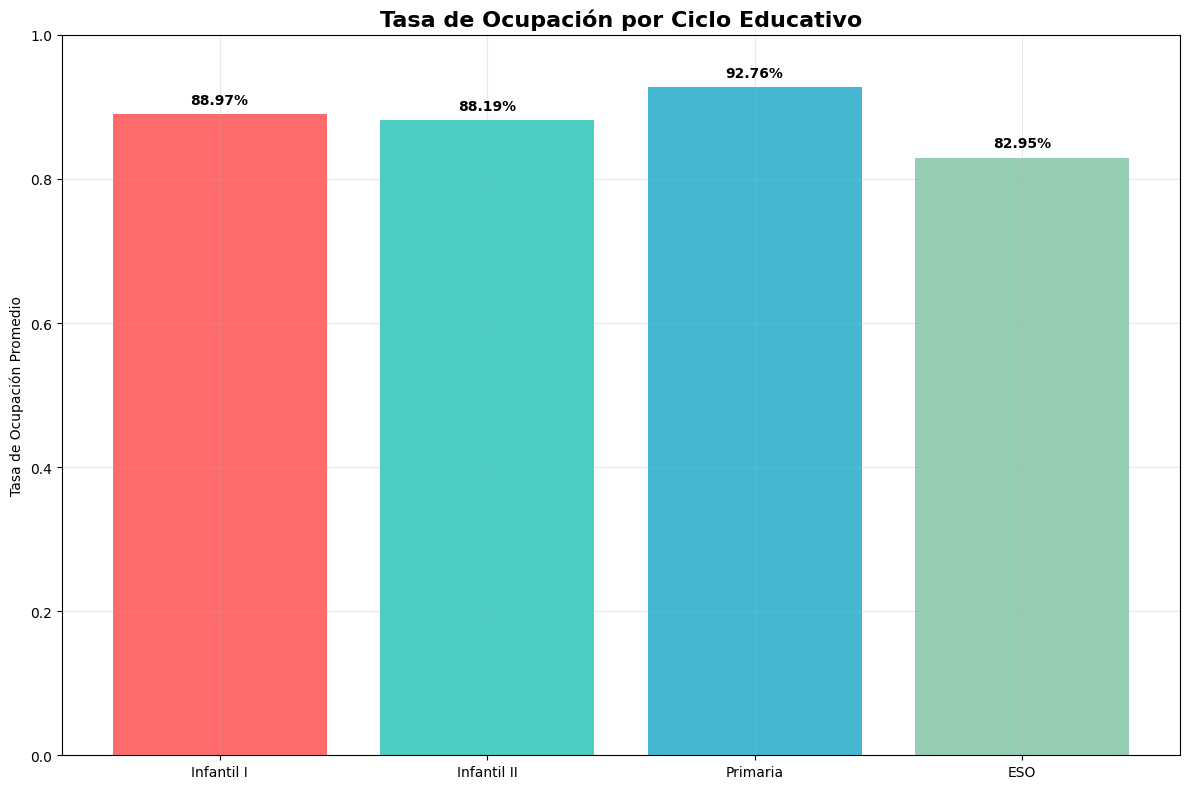


📊 GRÁFICA 1.B: DISTRIBUCIÓN DE TASAS DE OCUPACIÓN POR CICLO
📋 CÓMO INTERPRETAR:
   • Boxplot que muestra la variabilidad de ocupación entre centros individuales
   • Línea central: mediana (50% de centros por encima/debajo)
   • Caja: rango intercuartílico (25%-75% de los datos)
   • Bigotes: extensión de los datos normales
   • Puntos externos: centros con ocupación atípica (outliers)
   • Cajas más amplias = mayor variabilidad entre centros
   • n= número de centros incluidos en cada análisis


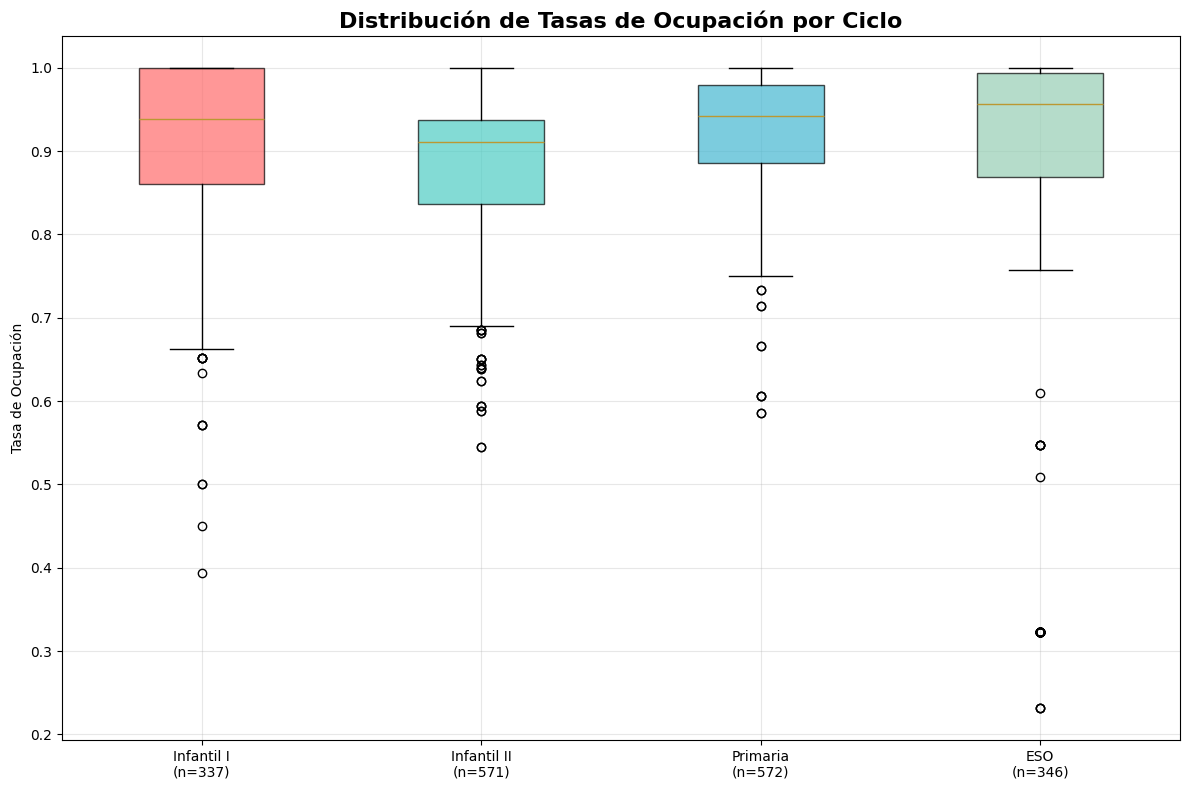


📊 GRÁFICA 2.1: RATIO DE DEMANDA - INFANTIL I
📋 CÓMO INTERPRETAR:
   • Histograma que muestra la distribución del ratio demanda/capacidad
   • Ratio de demanda = Solicitudes presentadas / Plazas estimadas
   • Línea roja discontinua (ratio=1): equilibrio perfecto demanda=capacidad
   • Valores > 1: demanda supera la capacidad (alta presión)
   • Valores < 1: capacidad supera la demanda (baja presión)
   • Línea azul continua: valor promedio del ratio
   • Concentración a la derecha de ratio=1 indica alta demanda generalizada


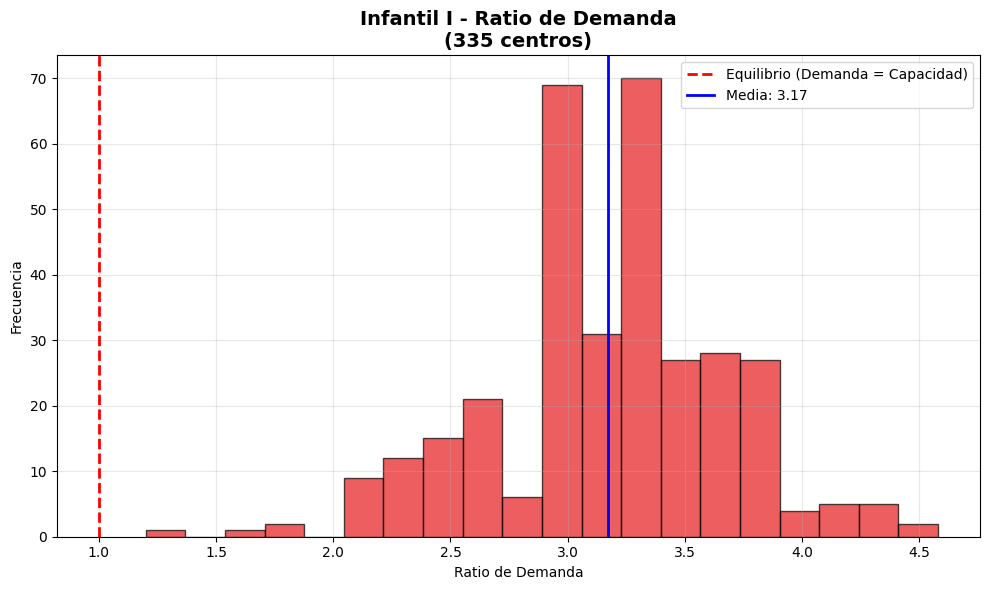


📊 GRÁFICA 2.2: RATIO DE DEMANDA - INFANTIL II
📋 CÓMO INTERPRETAR:
   • Histograma que muestra la distribución del ratio demanda/capacidad
   • Ratio de demanda = Solicitudes presentadas / Plazas estimadas
   • Línea roja discontinua (ratio=1): equilibrio perfecto demanda=capacidad
   • Valores > 1: demanda supera la capacidad (alta presión)
   • Valores < 1: capacidad supera la demanda (baja presión)
   • Línea azul continua: valor promedio del ratio
   • Concentración a la derecha de ratio=1 indica alta demanda generalizada


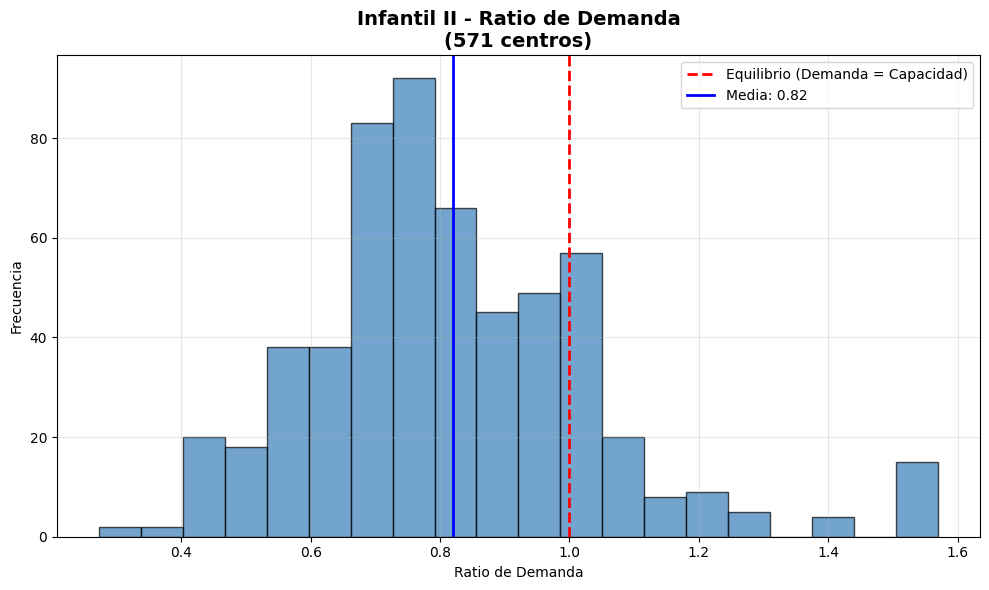


📊 GRÁFICA 2.3: RATIO DE DEMANDA - PRIMARIA
📋 CÓMO INTERPRETAR:
   • Histograma que muestra la distribución del ratio demanda/capacidad
   • Ratio de demanda = Solicitudes presentadas / Plazas estimadas
   • Línea roja discontinua (ratio=1): equilibrio perfecto demanda=capacidad
   • Valores > 1: demanda supera la capacidad (alta presión)
   • Valores < 1: capacidad supera la demanda (baja presión)
   • Línea azul continua: valor promedio del ratio
   • Concentración a la derecha de ratio=1 indica alta demanda generalizada


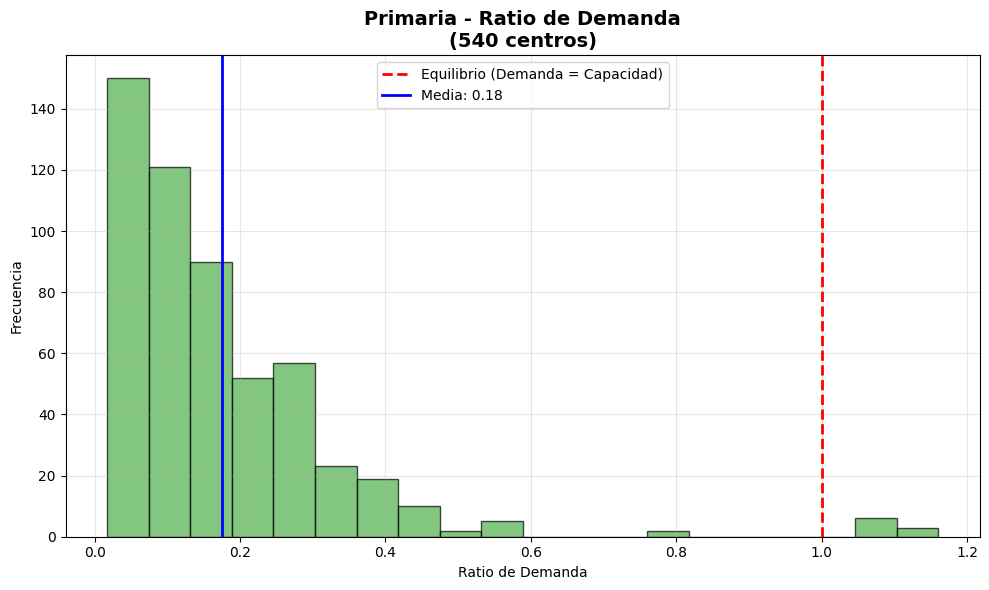


📊 GRÁFICA 2.4: RATIO DE DEMANDA - ESO
📋 CÓMO INTERPRETAR:
   • Histograma que muestra la distribución del ratio demanda/capacidad
   • Ratio de demanda = Solicitudes presentadas / Plazas estimadas
   • Línea roja discontinua (ratio=1): equilibrio perfecto demanda=capacidad
   • Valores > 1: demanda supera la capacidad (alta presión)
   • Valores < 1: capacidad supera la demanda (baja presión)
   • Línea azul continua: valor promedio del ratio
   • Concentración a la derecha de ratio=1 indica alta demanda generalizada


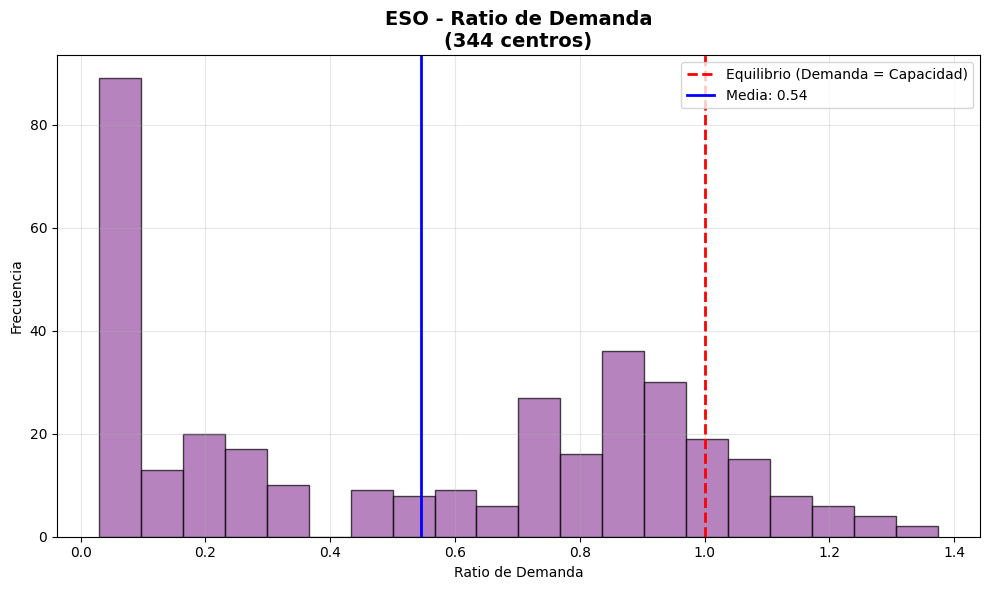


📊 GRÁFICA 3.A: EFICIENCIA DE ADMISIÓN PROMEDIO POR CICLO
📋 CÓMO INTERPRETAR:
   • Muestra qué porcentaje de solicitudes son finalmente admitidas
   • Eficiencia = Solicitudes admitidas / Solicitudes presentadas
   • 100% = todas las solicitudes son admitidas (sin restricciones)
   • Valores bajos indican alta selectividad o limitaciones de capacidad
   • Compare entre ciclos para identificar cuellos de botella
   • Valores muy altos pueden indicar baja demanda relativa


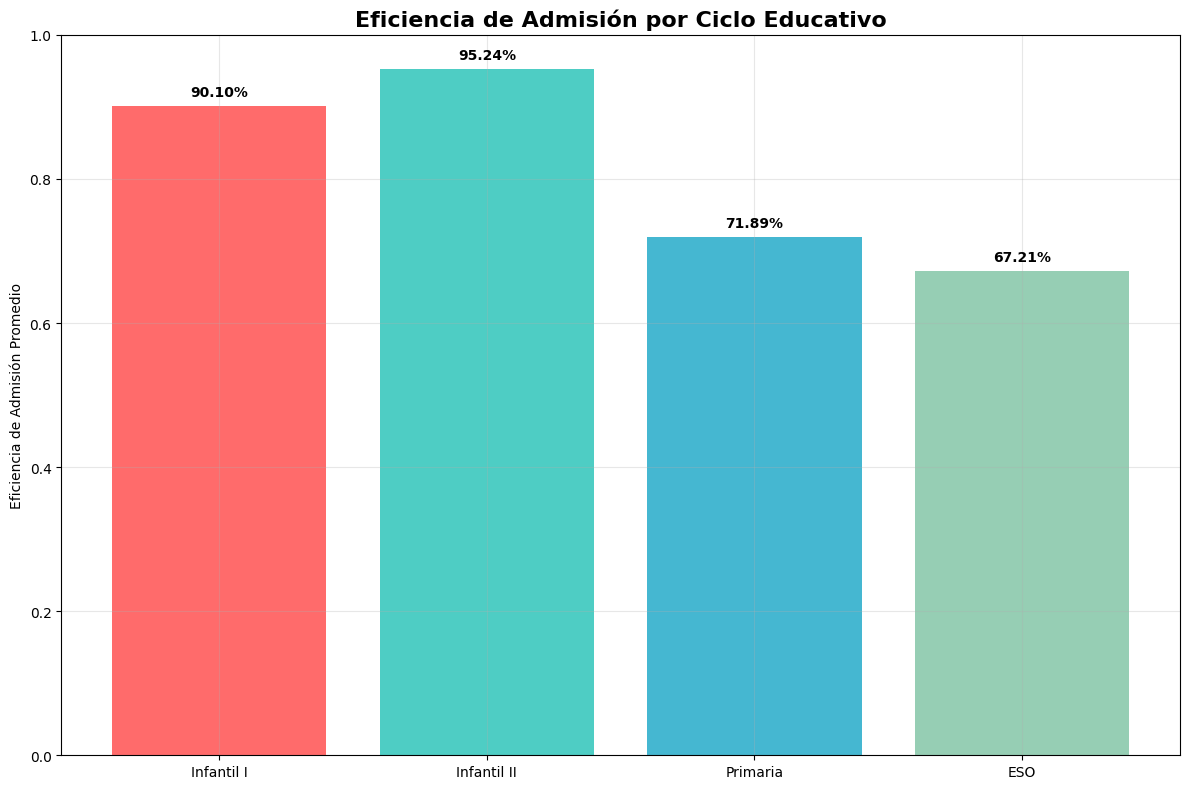


📊 GRÁFICA 3.B: RELACIÓN DEMANDA VS EFICIENCIA DE ADMISIÓN
📋 CÓMO INTERPRETAR:
   • Scatter plot que relaciona presión de demanda con eficiencia de admisión
   • Eje X: Ratio de demanda del centro (solicitudes/capacidad)
   • Eje Y: Eficiencia de admisión (% solicitudes admitidas)
   • Color: Tamaño del centro (plazas estimadas)
   • Patrón esperado: a mayor demanda, menor eficiencia
   • Centros en esquina superior izquierda: alta eficiencia, baja demanda
   • Centros en esquina inferior derecha: baja eficiencia, alta demanda


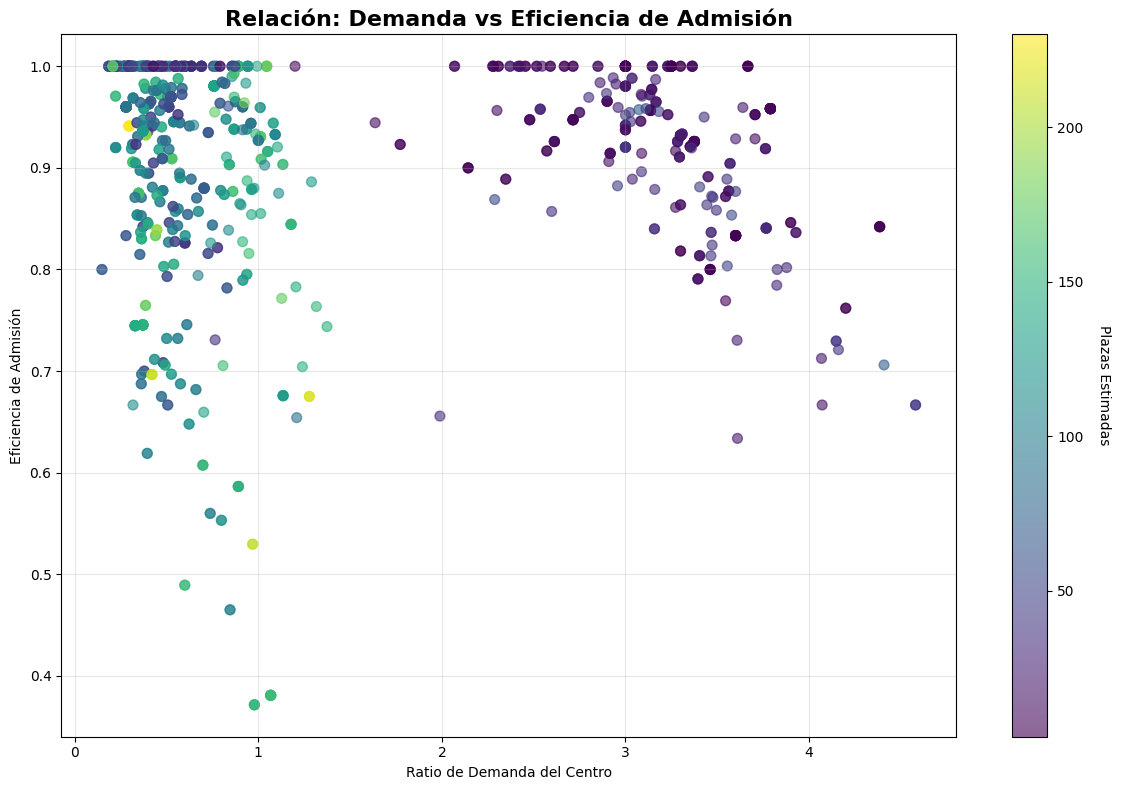


📊 GRÁFICA 4.1: ADMISIÓN VS CAPACIDAD - INFANTIL I
📋 CÓMO INTERPRETAR:
   • Scatter plot que relaciona tamaño del centro con utilización de capacidad
   • Eje X: Plazas estimadas del centro (tamaño)
   • Eje Y: Ratio admisión/capacidad (utilización)
   • Línea roja discontinua (ratio=1): capacidad completamente utilizada
   • Puntos por encima de la línea: sobre-utilización (más admisiones que capacidad)
   • Puntos por debajo: sub-utilización de la capacidad disponible
   • Identifica si centros grandes/pequeños tienen mejor utilización


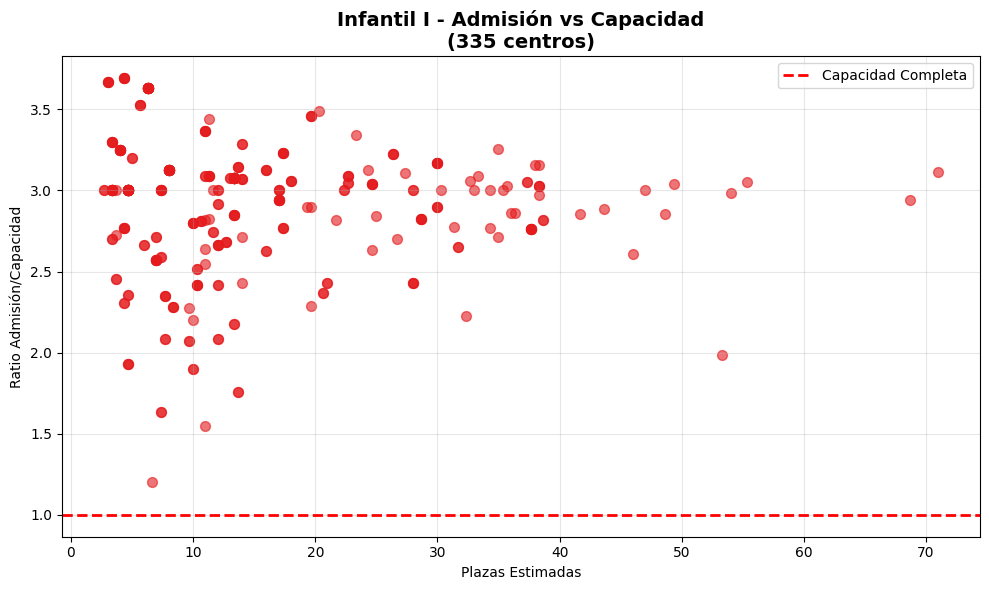


📊 GRÁFICA 4.2: ADMISIÓN VS CAPACIDAD - INFANTIL II
📋 CÓMO INTERPRETAR:
   • Scatter plot que relaciona tamaño del centro con utilización de capacidad
   • Eje X: Plazas estimadas del centro (tamaño)
   • Eje Y: Ratio admisión/capacidad (utilización)
   • Línea roja discontinua (ratio=1): capacidad completamente utilizada
   • Puntos por encima de la línea: sobre-utilización (más admisiones que capacidad)
   • Puntos por debajo: sub-utilización de la capacidad disponible
   • Identifica si centros grandes/pequeños tienen mejor utilización


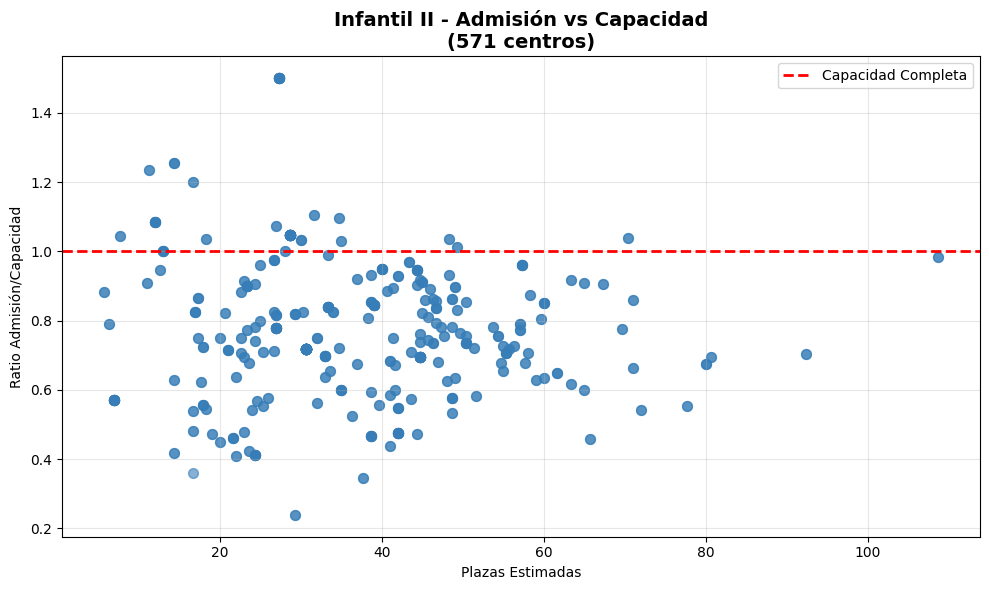


📊 GRÁFICA 4.3: ADMISIÓN VS CAPACIDAD - PRIMARIA
📋 CÓMO INTERPRETAR:
   • Scatter plot que relaciona tamaño del centro con utilización de capacidad
   • Eje X: Plazas estimadas del centro (tamaño)
   • Eje Y: Ratio admisión/capacidad (utilización)
   • Línea roja discontinua (ratio=1): capacidad completamente utilizada
   • Puntos por encima de la línea: sobre-utilización (más admisiones que capacidad)
   • Puntos por debajo: sub-utilización de la capacidad disponible
   • Identifica si centros grandes/pequeños tienen mejor utilización


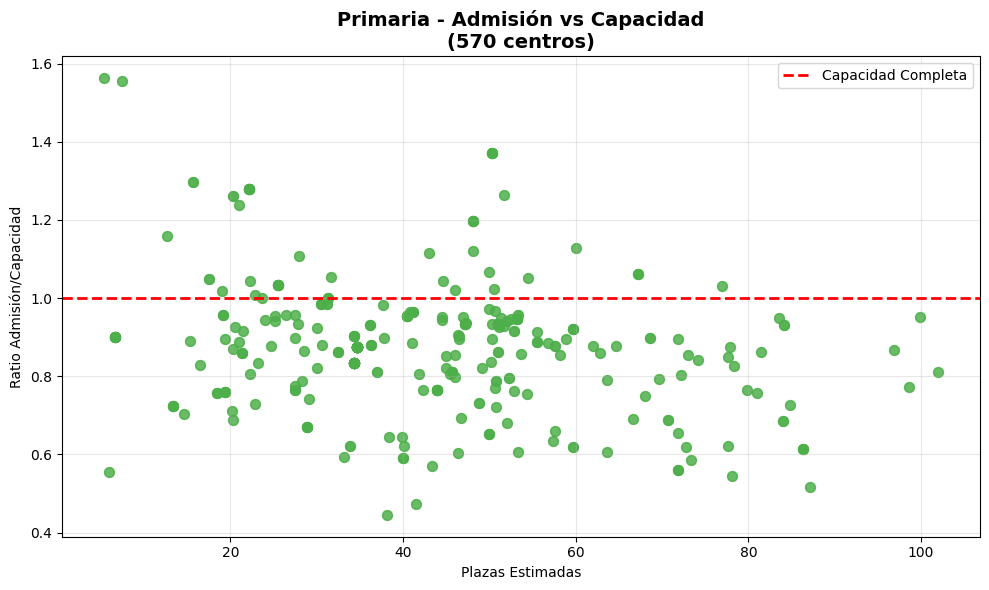


📊 GRÁFICA 4.4: ADMISIÓN VS CAPACIDAD - ESO
📋 CÓMO INTERPRETAR:
   • Scatter plot que relaciona tamaño del centro con utilización de capacidad
   • Eje X: Plazas estimadas del centro (tamaño)
   • Eje Y: Ratio admisión/capacidad (utilización)
   • Línea roja discontinua (ratio=1): capacidad completamente utilizada
   • Puntos por encima de la línea: sobre-utilización (más admisiones que capacidad)
   • Puntos por debajo: sub-utilización de la capacidad disponible
   • Identifica si centros grandes/pequeños tienen mejor utilización


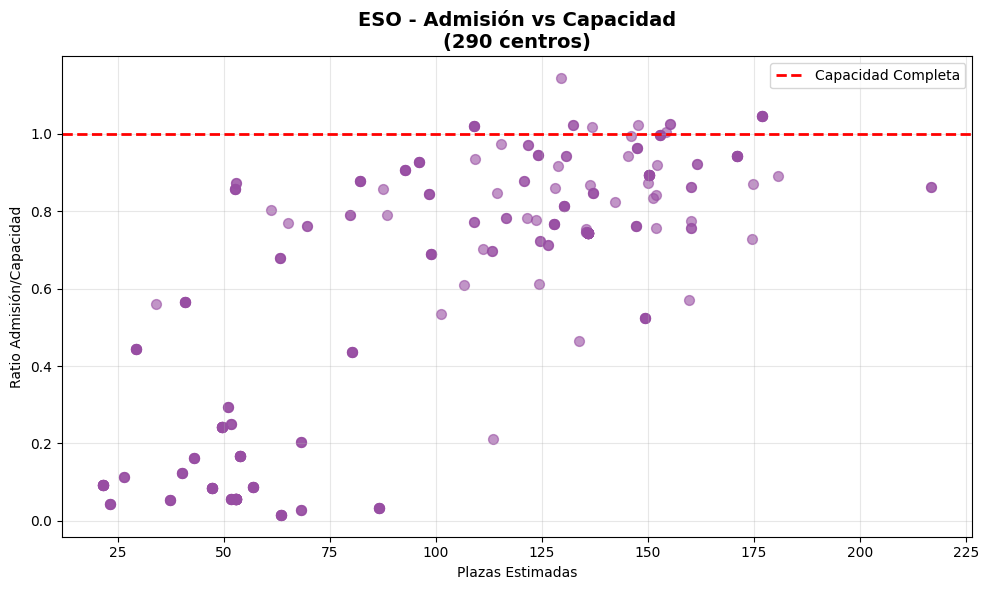


📊 GRÁFICA 5.A: DISTRIBUCIÓN DE COBERTURA EDUCATIVA MUNICIPAL
📋 CÓMO INTERPRETAR:
   • Histograma de cobertura educativa en municipios (población 1K-50K)
   • Cobertura = % de ciclos educativos cubiertos adecuadamente
   • Línea roja discontinua: cobertura promedio
   • Línea naranja continua: mediana de cobertura
   • Distribución hacia la derecha: mayoría de municipios bien cubiertos
   • Distribución hacia la izquierda: déficit generalizado de cobertura
   • Múltiples picos pueden indicar diferentes tipos de municipios


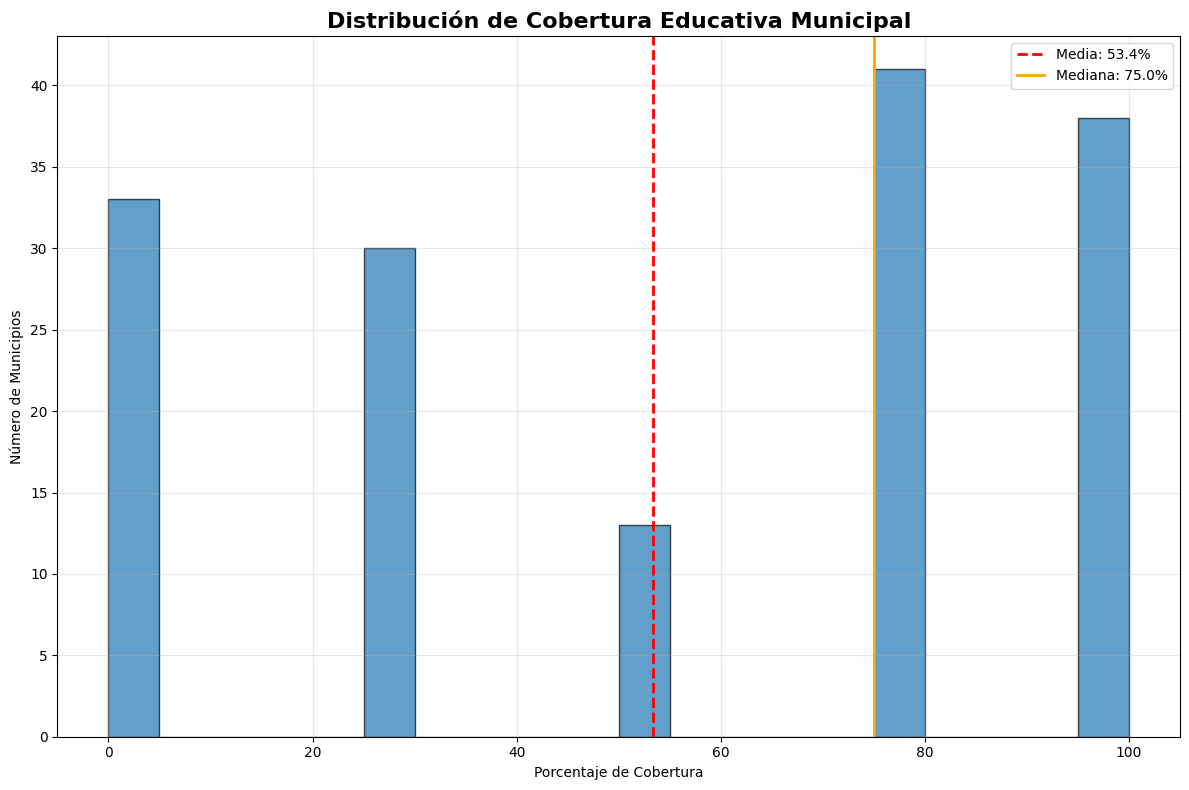


📊 GRÁFICA 5.B: COBERTURA MUNICIPAL POR CICLO EDUCATIVO
📋 CÓMO INTERPRETAR:
   • Porcentaje de municipios que tienen cobertura adecuada por ciclo
   • 100% = todos los municipios tienen capacidad suficiente para ese ciclo
   • Compare entre ciclos para identificar déficits sistemáticos
   • Ciclos con menor cobertura requieren mayor inversión/planificación
   • Considera la progresión natural: Infantil → Primaria → ESO
   • Valores bajos en ciclos obligatorios son más críticos


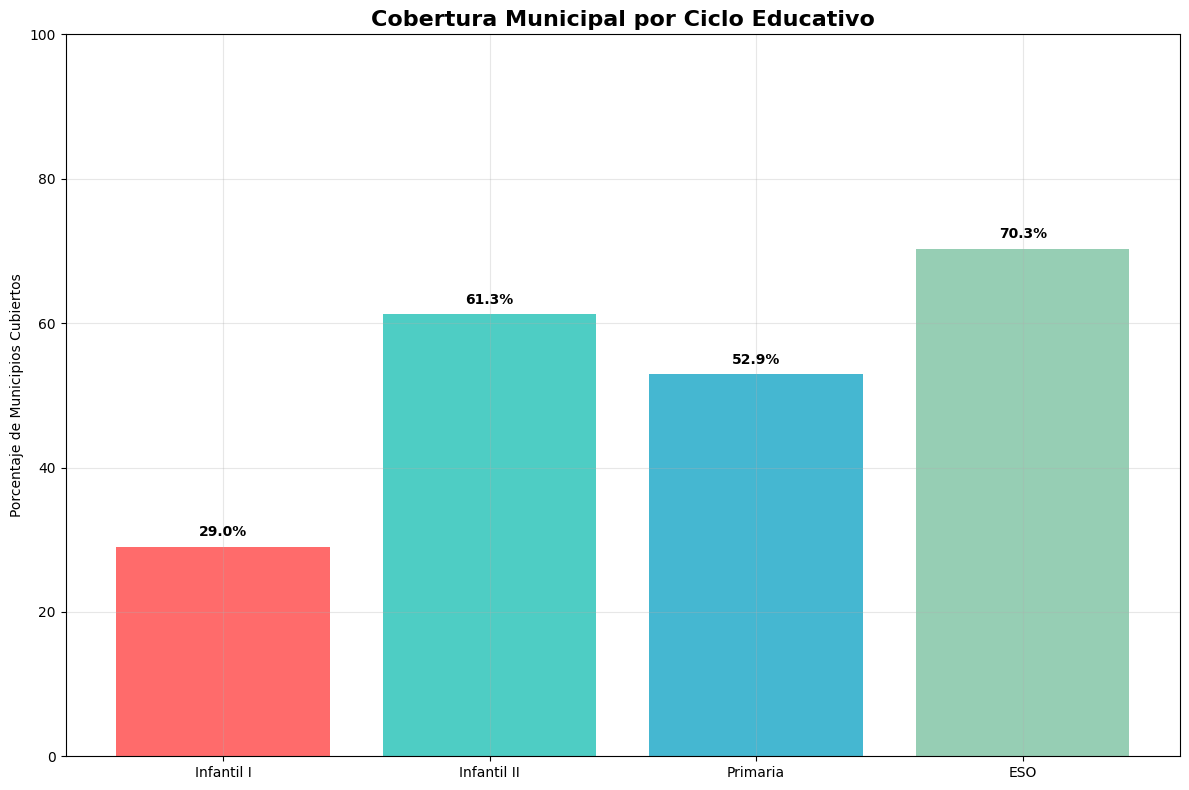


📊 GRÁFICA 6.A: DÉFICIT TOTAL DE PLAZAS POR CICLO
📋 CÓMO INTERPRETAR:
   • Número absoluto de plazas faltantes en todos los municipios
   • Déficit = max(0, necesidad estimada - capacidad actual)
   • Identifica qué ciclos requieren mayor inversión en infraestructura
   • Valores altos indican necesidad urgente de nuevos centros/ampliaciones
   • Considere la población objetivo de cada ciclo para priorizar
   • Útil para planificación presupuestaria y asignación de recursos


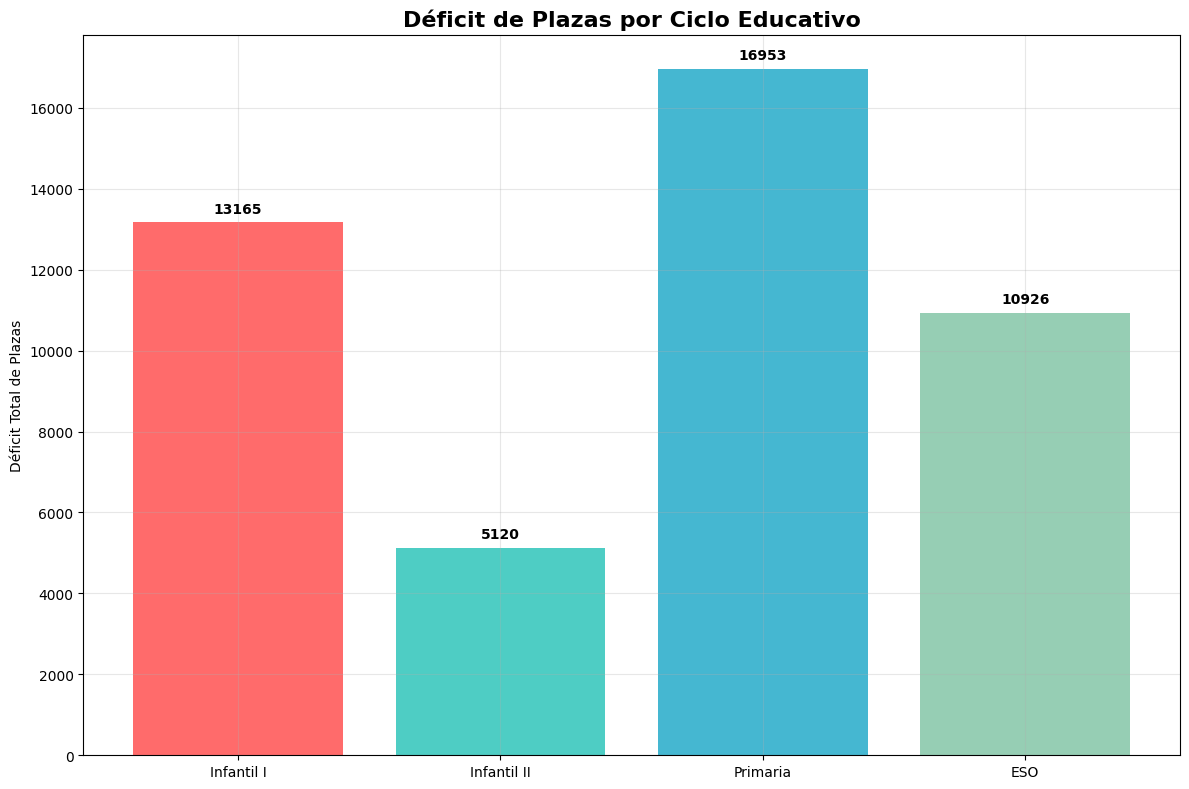


📊 GRÁFICA 6.B: TOP 10 MUNICIPIOS CON MAYOR DÉFICIT
📋 CÓMO INTERPRETAR:
   • Ranking de municipios que más necesitan inversión educativa
   • Déficit total = suma de déficits de todos los ciclos en el municipio
   • Municipios en la parte superior requieren intervención prioritaria
   • Números muestran plazas faltantes exactas para dimensionar inversión
   • Considere población y crecimiento demográfico para planificación
   • Útil para focalizar políticas públicas y asignación presupuestaria


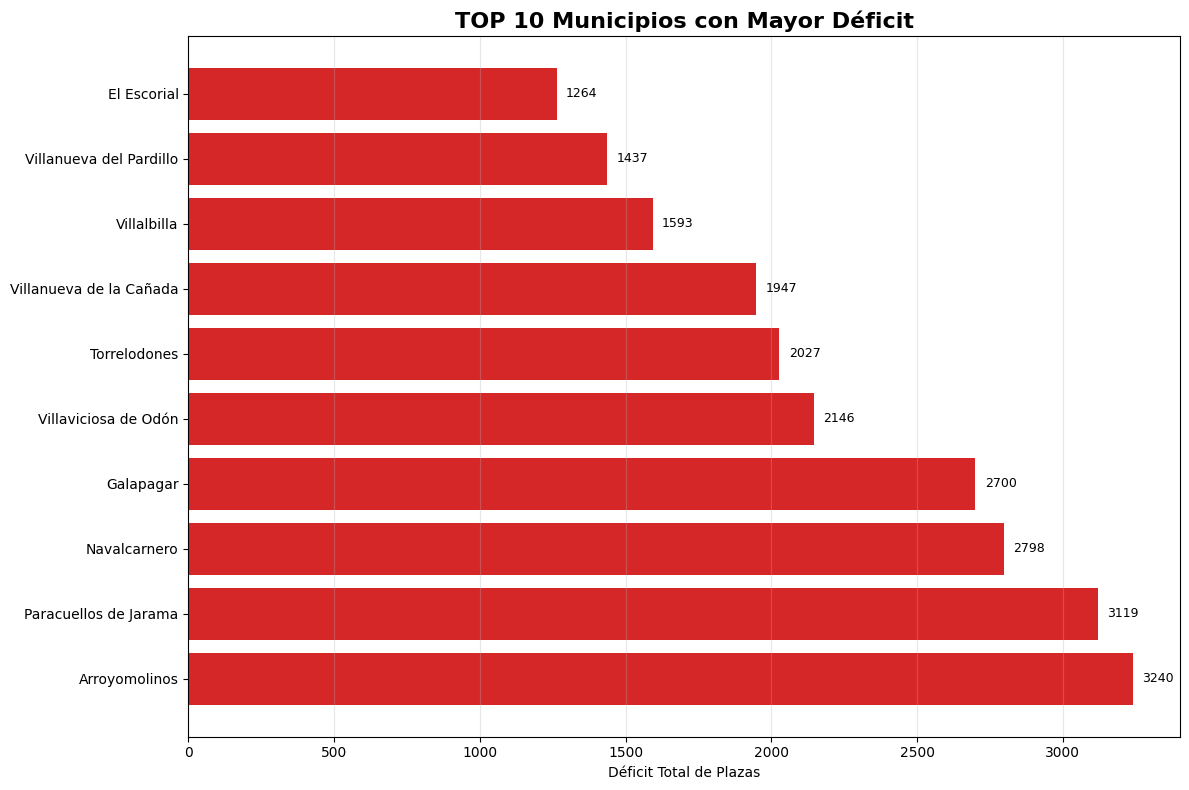


📊 GRÁFICA 7.A: DISTRIBUCIÓN DE CLASIFICACIÓN DE ACCESO EDUCATIVO
📋 CÓMO INTERPRETAR:
   • Gráfica de pastel que muestra calidad de acceso educativo municipal
   • Acceso Completo: 4 ciclos disponibles (situación ideal)
   • Acceso Bueno: 3 ciclos disponibles (falta 1 ciclo)
   • Acceso Parcial: 2 ciclos disponibles (déficit moderado)
   • Acceso Limitado: 1 ciclo disponible (déficit severo)
   • Sin Acceso: 0 ciclos disponibles (situación crítica)
   • Porcentajes altos en categorías superiores indican buena cobertura regional


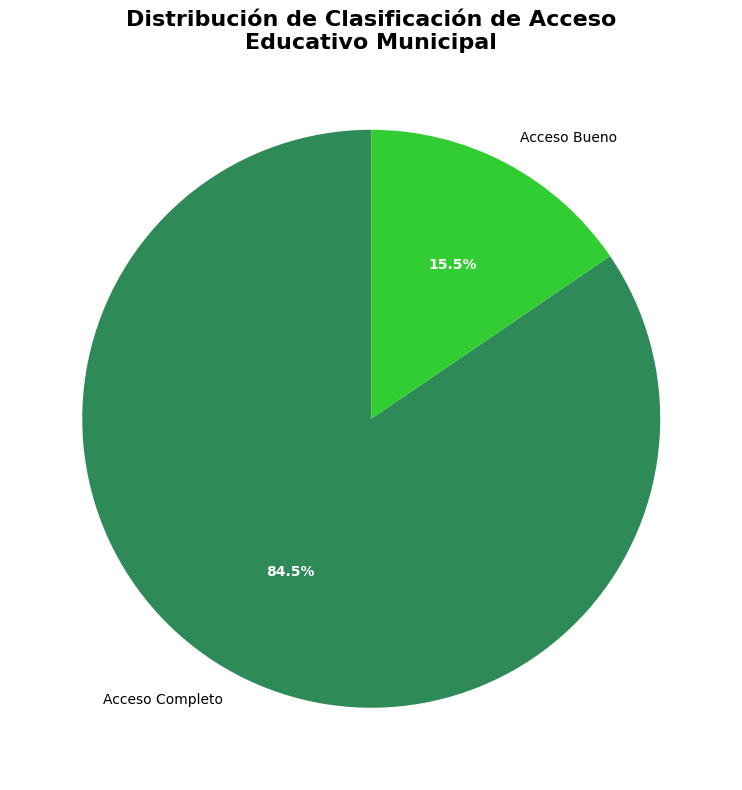


📊 GRÁFICA 7.B: MUNICIPIOS POR NÚMERO DE CICLOS DISPONIBLES
📋 CÓMO INTERPRETAR:
   • Distribución de municipios según número de ciclos educativos ofertados
   • Eje X: Número de ciclos disponibles (0-4)
   • Eje Y: Cantidad de municipios en cada categoría
   • Distribución ideal: mayoría de municipios con 3-4 ciclos
   • Muchos municipios con 0-1 ciclos indica problema de accesibilidad
   • Útil para evaluar equidad territorial en acceso educativo
   • Números sobre barras muestran cantidad exacta de municipios


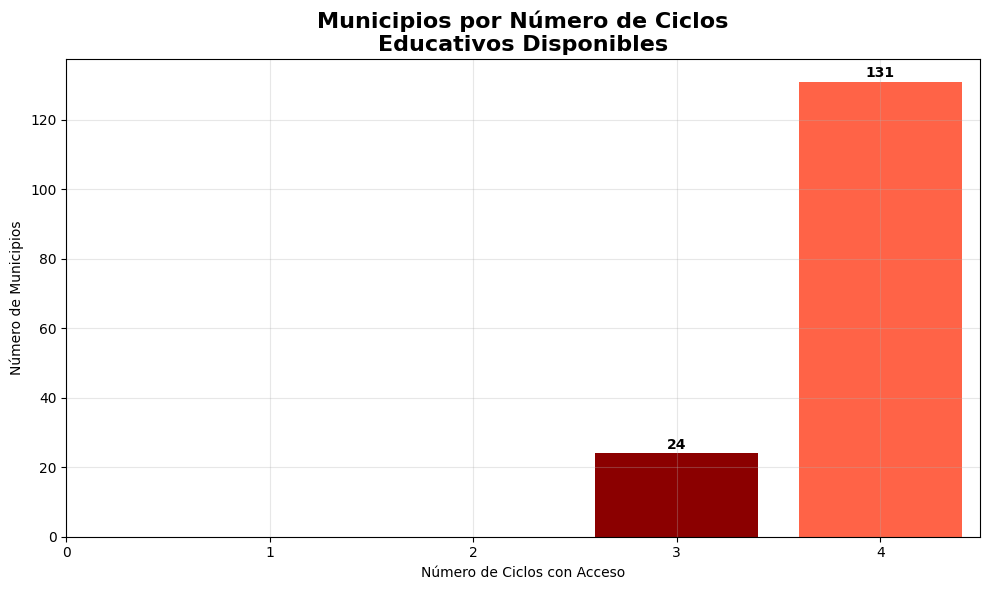

In [10]:
# === MÉTRICAS EDUCATIVAS ESPECÍFICAS ===

print("\n" + "="*80)
print("📚 VISUALIZACIONES DE MÉTRICAS EDUCATIVAS ESPECÍFICAS")
print("="*80)

valid_cycles = ['infantil_i_ciclo', 'infantil_ii_ciclo', 'primaria', 'eso']
cycle_names = ['Infantil I', 'Infantil II', 'Primaria', 'ESO']

# 1.A. TASA DE OCUPACIÓN PROMEDIO POR CICLO
print("\n" + "="*80)
print("📊 GRÁFICA 1.A: TASA DE OCUPACIÓN PROMEDIO POR CICLO")
print("="*80)
print("📋 CÓMO INTERPRETAR:")
print("   • Esta gráfica muestra el promedio de ocupación de todos los centros por ciclo educativo")
print("   • Tasa de ocupación = Matriculados 2022-23 / Máximo histórico de matriculados")
print("   • Valores cercanos a 100% indican centros utilizando su capacidad máxima histórica")
print("   • Valores bajos pueden indicar subutilización o reducción de demanda")
print("   • Compare entre ciclos para identificar patrones de uso")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Tasa de ocupación promedio por ciclo
occupation_rates = []
for cycle in valid_cycles:
    cycle_data = centers_viz_df[centers_viz_df[f'{cycle}_activo'] == 1]
    if len(cycle_data) > 0:
        avg_occupation = cycle_data[f'{cycle}_tasa_ocupacion'].mean()
        occupation_rates.append(avg_occupation)
    else:
        occupation_rates.append(0)

bars = ax.bar(cycle_names, occupation_rates, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax.set_ylabel('Tasa de Ocupación Promedio')
ax.set_title('Tasa de Ocupación por Ciclo Educativo', fontweight='bold', fontsize=16)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, rate in zip(bars, occupation_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rate:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 1.B. DISTRIBUCIÓN DE TASAS DE OCUPACIÓN POR CICLO
print("\n" + "="*80)
print("📊 GRÁFICA 1.B: DISTRIBUCIÓN DE TASAS DE OCUPACIÓN POR CICLO")
print("="*80)
print("📋 CÓMO INTERPRETAR:")
print("   • Boxplot que muestra la variabilidad de ocupación entre centros individuales")
print("   • Línea central: mediana (50% de centros por encima/debajo)")
print("   • Caja: rango intercuartílico (25%-75% de los datos)")
print("   • Bigotes: extensión de los datos normales")
print("   • Puntos externos: centros con ocupación atípica (outliers)")
print("   • Cajas más amplias = mayor variabilidad entre centros")
print("   • n= número de centros incluidos en cada análisis")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Boxplot de distribución de tasas de ocupación
occupation_data = []
occupation_labels = []

for cycle, cycle_name in zip(valid_cycles, cycle_names):
    cycle_occupation = centers_viz_df[
        (centers_viz_df[f'{cycle}_activo'] == 1) &
        (centers_viz_df[f'{cycle}_tasa_ocupacion'] > 0)
    ][f'{cycle}_tasa_ocupacion']

    if len(cycle_occupation) > 0:
        occupation_data.append(cycle_occupation)
        occupation_labels.append(f'{cycle_name}\n(n={len(cycle_occupation)})')

if occupation_data:
    bp = ax.boxplot(occupation_data, labels=occupation_labels, patch_artist=True)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

ax.set_ylabel('Tasa de Ocupación')
ax.set_title('Distribución de Tasas de Ocupación por Ciclo', fontweight='bold', fontsize=16)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. RATIO DE DEMANDA POR CICLO (GRÁFICAS SEPARADAS)
for i, (cycle, cycle_name) in enumerate(zip(valid_cycles, cycle_names)):
    print(f"\n" + "="*80)
    print(f"📊 GRÁFICA 2.{i+1}: RATIO DE DEMANDA - {cycle_name.upper()}")
    print("="*80)
    print("📋 CÓMO INTERPRETAR:")
    print("   • Histograma que muestra la distribución del ratio demanda/capacidad")
    print("   • Ratio de demanda = Solicitudes presentadas / Plazas estimadas")
    print("   • Línea roja discontinua (ratio=1): equilibrio perfecto demanda=capacidad")
    print("   • Valores > 1: demanda supera la capacidad (alta presión)")
    print("   • Valores < 1: capacidad supera la demanda (baja presión)")
    print("   • Línea azul continua: valor promedio del ratio")
    print("   • Concentración a la derecha de ratio=1 indica alta demanda generalizada")
    print("="*80)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    cycle_data = centers_viz_df[
        (centers_viz_df[f'{cycle}_activo'] == 1) &
        (centers_viz_df[f'{cycle}_ratio_demanda'] > 0) &
        (centers_viz_df[f'{cycle}_ratio_demanda'] < 5)  # Filtrar outliers extremos
    ]

    if len(cycle_data) > 0:
        # Histograma de ratio de demanda
        ax.hist(cycle_data[f'{cycle}_ratio_demanda'], bins=20, alpha=0.7,
                color=plt.cm.Set1(i), edgecolor='black')

        # Línea vertical en ratio = 1 (equilibrio)
        ax.axvline(x=1, color='red', linestyle='--', linewidth=2,
                   label='Equilibrio (Demanda = Capacidad)')

        # Estadísticas
        mean_ratio = cycle_data[f'{cycle}_ratio_demanda'].mean()
        ax.axvline(x=mean_ratio, color='blue', linestyle='-', linewidth=2,
                   label=f'Media: {mean_ratio:.2f}')

        ax.set_xlabel('Ratio de Demanda')
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'{cycle_name} - Ratio de Demanda\n({len(cycle_data)} centros)',
                     fontweight='bold', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'Sin datos\npara {cycle_name}',
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{cycle_name} - Ratio de Demanda', fontweight='bold', fontsize=14)

    plt.tight_layout()
    plt.show()

# 3.A. EFICIENCIA DE ADMISIÓN PROMEDIO POR CICLO
print("\n" + "="*80)
print("📊 GRÁFICA 3.A: EFICIENCIA DE ADMISIÓN PROMEDIO POR CICLO")
print("="*80)
print("📋 CÓMO INTERPRETAR:")
print("   • Muestra qué porcentaje de solicitudes son finalmente admitidas")
print("   • Eficiencia = Solicitudes admitidas / Solicitudes presentadas")
print("   • 100% = todas las solicitudes son admitidas (sin restricciones)")
print("   • Valores bajos indican alta selectividad o limitaciones de capacidad")
print("   • Compare entre ciclos para identificar cuellos de botella")
print("   • Valores muy altos pueden indicar baja demanda relativa")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Eficiencia promedio por ciclo
efficiency_rates = []
for cycle in valid_cycles:
    cycle_data = centers_viz_df[centers_viz_df[f'{cycle}_activo'] == 1]
    if len(cycle_data) > 0:
        avg_efficiency = cycle_data[f'{cycle}_eficiencia_admision'].mean()
        efficiency_rates.append(avg_efficiency)
    else:
        efficiency_rates.append(0)

bars = ax.bar(cycle_names, efficiency_rates, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax.set_ylabel('Eficiencia de Admisión Promedio')
ax.set_title('Eficiencia de Admisión por Ciclo Educativo', fontweight='bold', fontsize=16)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, rate in zip(bars, efficiency_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rate:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 3.B. RELACIÓN: DEMANDA VS EFICIENCIA DE ADMISIÓN
print("\n" + "="*80)
print("📊 GRÁFICA 3.B: RELACIÓN DEMANDA VS EFICIENCIA DE ADMISIÓN")
print("="*80)
print("📋 CÓMO INTERPRETAR:")
print("   • Scatter plot que relaciona presión de demanda con eficiencia de admisión")
print("   • Eje X: Ratio de demanda del centro (solicitudes/capacidad)")
print("   • Eje Y: Eficiencia de admisión (% solicitudes admitidas)")
print("   • Color: Tamaño del centro (plazas estimadas)")
print("   • Patrón esperado: a mayor demanda, menor eficiencia")
print("   • Centros en esquina superior izquierda: alta eficiencia, baja demanda")
print("   • Centros en esquina inferior derecha: baja eficiencia, alta demanda")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Scatter plot: Ratio Demanda vs Eficiencia Admisión
centers_valid = centers_viz_df[
    (centers_viz_df['ratio_demanda_centro'] > 0) &
    (centers_viz_df['ratio_demanda_centro'] < 5) &
    (centers_viz_df['eficiencia_admision_centro'] >= 0) &
    (centers_viz_df['eficiencia_admision_centro'] <= 1)
]

scatter = ax.scatter(centers_valid['ratio_demanda_centro'],
                     centers_valid['eficiencia_admision_centro'],
                     alpha=0.6, s=50, c=centers_valid['total_plazas_estimadas'],
                     cmap='viridis')

ax.set_xlabel('Ratio de Demanda del Centro')
ax.set_ylabel('Eficiencia de Admisión')
ax.set_title('Relación: Demanda vs Eficiencia de Admisión', fontweight='bold', fontsize=16)
ax.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Plazas Estimadas', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

# 4. RATIO DE ADMISIÓN VS CAPACIDAD (GRÁFICAS SEPARADAS)
for i, (cycle, cycle_name) in enumerate(zip(valid_cycles, cycle_names)):
    print(f"\n" + "="*80)
    print(f"📊 GRÁFICA 4.{i+1}: ADMISIÓN VS CAPACIDAD - {cycle_name.upper()}")
    print("="*80)
    print("📋 CÓMO INTERPRETAR:")
    print("   • Scatter plot que relaciona tamaño del centro con utilización de capacidad")
    print("   • Eje X: Plazas estimadas del centro (tamaño)")
    print("   • Eje Y: Ratio admisión/capacidad (utilización)")
    print("   • Línea roja discontinua (ratio=1): capacidad completamente utilizada")
    print("   • Puntos por encima de la línea: sobre-utilización (más admisiones que capacidad)")
    print("   • Puntos por debajo: sub-utilización de la capacidad disponible")
    print("   • Identifica si centros grandes/pequeños tienen mejor utilización")
    print("="*80)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    cycle_data = centers_viz_df[
        (centers_viz_df[f'{cycle}_activo'] == 1) &
        (centers_viz_df[f'{cycle}_ratio_admision_capacidad'] > 0)
    ]

    if len(cycle_data) > 0:
        # Scatter plot: Plazas vs Ratio Admisión/Capacidad
        scatter = ax.scatter(cycle_data[f'{cycle}_plazas_estimadas'],
                             cycle_data[f'{cycle}_ratio_admision_capacidad'],
                             alpha=0.6, s=50, color=plt.cm.Set1(i))

        # Línea horizontal en ratio = 1 (capacidad completa)
        ax.axhline(y=1, color='red', linestyle='--', linewidth=2,
                   label='Capacidad Completa')

        ax.set_xlabel('Plazas Estimadas')
        ax.set_ylabel('Ratio Admisión/Capacidad')
        ax.set_title(f'{cycle_name} - Admisión vs Capacidad\n({len(cycle_data)} centros)',
                     fontweight='bold', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'Sin datos\npara {cycle_name}',
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{cycle_name} - Admisión vs Capacidad', fontweight='bold', fontsize=14)

    plt.tight_layout()
    plt.show()

# 5.A. DISTRIBUCIÓN DE COBERTURA EDUCATIVA MUNICIPAL
print("\n" + "="*80)
print("📊 GRÁFICA 5.A: DISTRIBUCIÓN DE COBERTURA EDUCATIVA MUNICIPAL")
print("="*80)
print("📋 CÓMO INTERPRETAR:")
print("   • Histograma de cobertura educativa en municipios (población 1K-50K)")
print("   • Cobertura = % de ciclos educativos cubiertos adecuadamente")
print("   • Línea roja discontinua: cobertura promedio")
print("   • Línea naranja continua: mediana de cobertura")
print("   • Distribución hacia la derecha: mayoría de municipios bien cubiertos")
print("   • Distribución hacia la izquierda: déficit generalizado de cobertura")
print("   • Múltiples picos pueden indicar diferentes tipos de municipios")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Distribución de cobertura municipal
coverage_data = municipal_viz_df[municipal_viz_df['coverage_percentage'] >= 0]['coverage_percentage']

ax.hist(coverage_data, bins=20, alpha=0.7, color=COLORS['primary'], edgecolor='black')
ax.axvline(x=coverage_data.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Media: {coverage_data.mean():.1f}%')
ax.axvline(x=coverage_data.median(), color='orange', linestyle='-', linewidth=2,
           label=f'Mediana: {coverage_data.median():.1f}%')

ax.set_xlabel('Porcentaje de Cobertura')
ax.set_ylabel('Número de Municipios')
ax.set_title('Distribución de Cobertura Educativa Municipal', fontweight='bold', fontsize=16)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5.B. COBERTURA MUNICIPAL POR CICLO EDUCATIVO
print("\n" + "="*80)
print("📊 GRÁFICA 5.B: COBERTURA MUNICIPAL POR CICLO EDUCATIVO")
print("="*80)
print("📋 CÓMO INTERPRETAR:")
print("   • Porcentaje de municipios que tienen cobertura adecuada por ciclo")
print("   • 100% = todos los municipios tienen capacidad suficiente para ese ciclo")
print("   • Compare entre ciclos para identificar déficits sistemáticos")
print("   • Ciclos con menor cobertura requieren mayor inversión/planificación")
print("   • Considera la progresión natural: Infantil → Primaria → ESO")
print("   • Valores bajos en ciclos obligatorios son más críticos")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Cobertura por ciclo específico
coverage_by_cycle = []
for cycle in valid_cycles:
    coverage = municipal_viz_df[municipal_viz_df[f'{cycle}_is_covered'] == True]
    coverage_percentage = (len(coverage) / len(municipal_viz_df)) * 100
    coverage_by_cycle.append(coverage_percentage)

bars = ax.bar(cycle_names, coverage_by_cycle, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax.set_ylabel('Porcentaje de Municipios Cubiertos')
ax.set_title('Cobertura Municipal por Ciclo Educativo', fontweight='bold', fontsize=16)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, coverage in zip(bars, coverage_by_cycle):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{coverage:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 6.A. DÉFICIT TOTAL DE PLAZAS POR CICLO
print("\n" + "="*80)
print("📊 GRÁFICA 6.A: DÉFICIT TOTAL DE PLAZAS POR CICLO")
print("="*80)
print("📋 CÓMO INTERPRETAR:")
print("   • Número absoluto de plazas faltantes en todos los municipios")
print("   • Déficit = max(0, necesidad estimada - capacidad actual)")
print("   • Identifica qué ciclos requieren mayor inversión en infraestructura")
print("   • Valores altos indican necesidad urgente de nuevos centros/ampliaciones")
print("   • Considere la población objetivo de cada ciclo para priorizar")
print("   • Útil para planificación presupuestaria y asignación de recursos")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Déficit total por ciclo
deficit_by_cycle = []
for cycle in valid_cycles:
    total_deficit = municipal_viz_df[f'{cycle}_deficit'].sum()
    deficit_by_cycle.append(total_deficit)

bars = ax.bar(cycle_names, deficit_by_cycle, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax.set_ylabel('Déficit Total de Plazas')
ax.set_title('Déficit de Plazas por Ciclo Educativo', fontweight='bold', fontsize=16)
ax.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, deficit in zip(bars, deficit_by_cycle):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(deficit_by_cycle)*0.01,
             f'{deficit:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 6.B. TOP 10 MUNICIPIOS CON MAYOR DÉFICIT
print("\n" + "="*80)
print("📊 GRÁFICA 6.B: TOP 10 MUNICIPIOS CON MAYOR DÉFICIT")
print("="*80)
print("📋 CÓMO INTERPRETAR:")
print("   • Ranking de municipios que más necesitan inversión educativa")
print("   • Déficit total = suma de déficits de todos los ciclos en el municipio")
print("   • Municipios en la parte superior requieren intervención prioritaria")
print("   • Números muestran plazas faltantes exactas para dimensionar inversión")
print("   • Considere población y crecimiento demográfico para planificación")
print("   • Útil para focalizar políticas públicas y asignación presupuestaria")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

top_deficit = municipal_viz_df.nlargest(10, 'total_deficit')
if len(top_deficit) > 0:
    bars = ax.barh(range(len(top_deficit)), top_deficit['total_deficit'], color=COLORS['danger'])
    ax.set_yticks(range(len(top_deficit)))
    ax.set_yticklabels(top_deficit['municipality_name'], fontsize=10)
    ax.set_xlabel('Déficit Total de Plazas')
    ax.set_title('TOP 10 Municipios con Mayor Déficit', fontweight='bold', fontsize=16)
    ax.grid(axis='x', alpha=0.3)

    # Agregar valores en las barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + max(top_deficit['total_deficit'])*0.01, bar.get_y() + bar.get_height()/2,
                 f'{width:.0f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 7.A. DISTRIBUCIÓN DE CLASIFICACIÓN DE ACCESO
print("\n" + "="*80)
print("📊 GRÁFICA 7.A: DISTRIBUCIÓN DE CLASIFICACIÓN DE ACCESO EDUCATIVO")
print("="*80)
print("📋 CÓMO INTERPRETAR:")
print("   • Gráfica de pastel que muestra calidad de acceso educativo municipal")
print("   • Acceso Completo: 4 ciclos disponibles (situación ideal)")
print("   • Acceso Bueno: 3 ciclos disponibles (falta 1 ciclo)")
print("   • Acceso Parcial: 2 ciclos disponibles (déficit moderado)")
print("   • Acceso Limitado: 1 ciclo disponible (déficit severo)")
print("   • Sin Acceso: 0 ciclos disponibles (situación crítica)")
print("   • Porcentajes altos en categorías superiores indican buena cobertura regional")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Distribución de clasificación de acceso
access_counts = municipal_viz_df['access_classification'].value_counts()
colors_access = ['#2E8B57', '#32CD32', '#FFD700', '#FF6347', '#8B0000']

wedges, texts, autotexts = ax.pie(access_counts.values, labels=access_counts.index,
                                  autopct='%1.1f%%', colors=colors_access[:len(access_counts)],
                                  startangle=90)
ax.set_title('Distribución de Clasificación de Acceso\nEducativo Municipal', fontweight='bold', fontsize=16)

# Mejorar el formato del texto
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# 7.B. MUNICIPIOS POR NÚMERO DE CICLOS DISPONIBLES
print("\n" + "="*80)
print("📊 GRÁFICA 7.B: MUNICIPIOS POR NÚMERO DE CICLOS DISPONIBLES")
print("="*80)
print("📋 CÓMO INTERPRETAR:")
print("   • Distribución de municipios según número de ciclos educativos ofertados")
print("   • Eje X: Número de ciclos disponibles (0-4)")
print("   • Eje Y: Cantidad de municipios en cada categoría")
print("   • Distribución ideal: mayoría de municipios con 3-4 ciclos")
print("   • Muchos municipios con 0-1 ciclos indica problema de accesibilidad")
print("   • Útil para evaluar equidad territorial en acceso educativo")
print("   • Números sobre barras muestran cantidad exacta de municipios")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Acceso por número de ciclos
cycles_access = municipal_viz_df['cycles_with_access'].value_counts().sort_index()
bars = ax.bar(cycles_access.index, cycles_access.values,
              color=['#8B0000', '#FF6347', '#FFD700', '#32CD32', '#2E8B57'])
ax.set_xlabel('Número de Ciclos con Acceso')
ax.set_ylabel('Número de Municipios')
ax.set_title('Municipios por Número de Ciclos\nEducativos Disponibles', fontweight='bold', fontsize=16)
ax.set_xticks(range(5))
ax.set_xticklabels(['0', '1', '2', '3', '4'])
ax.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [11]:
# === RESUMEN ESTADÍSTICO DE LAS MÉTRICAS EDUCATIVAS ===

print("\n" + "="*80)
print("📋 RESUMEN ESTADÍSTICO DE MÉTRICAS EDUCATIVAS")
print("="*80)

print("\n🏛️ ESTADÍSTICAS MUNICIPALES:")
print(f"   • Total municipios analizados: {len(municipal_viz_df)}")
print(f"   • Municipios con acceso completo: {len(municipal_viz_df[municipal_viz_df['access_classification'] == 'Acceso Completo'])}")
print(f"   • Municipios sin acceso: {len(municipal_viz_df[municipal_viz_df['access_classification'] == 'Sin Acceso'])}")
print(f"   • Cobertura promedio: {municipal_viz_df['coverage_percentage'].mean():.1f}%")
print(f"   • Municipios completamente cubiertos: {len(municipal_viz_df[municipal_viz_df['is_fully_covered'] == True])}")
print(f"   • Déficit total estimado: {municipal_viz_df['total_deficit'].sum():.0f} plazas")

print("\n🏫 ESTADÍSTICAS DE CENTROS:")
print(f"   • Total centros analizados: {len(centers_viz_df)}")
print(f"   • Promedio plazas por centro: {centers_viz_df['total_plazas_estimadas'].mean():.2f}")
print(f"   • Centros con alta demanda (ratio > 2): {len(centers_viz_df[centers_viz_df['ratio_demanda_centro'] > 2])}")
print(f"   • Eficiencia promedio de admisión: {centers_viz_df['eficiencia_admision_centro'].mean():.2%}")

print("\n📊 MÉTRICAS POR CICLO:")
for cycle, cycle_name in zip(valid_cycles, cycle_names):
    active_centers = centers_viz_df[centers_viz_df[f'{cycle}_activo'] == 1]
    if len(active_centers) > 0:
        avg_occupation = active_centers[f'{cycle}_tasa_ocupacion'].mean()
        avg_demand = active_centers[f'{cycle}_ratio_demanda'].mean()
        print(f"   • {cycle_name}: {len(active_centers)} centros, ocupación {avg_occupation:.1%}, demanda {avg_demand:.2f}")

print("\n" + "="*80)
print("✅ MÉTRICAS EDUCATIVAS ESPECÍFICAS COMPLETADAS")
print("="*80)
print("Visualizaciones generadas:")
print("📊 1. Tasa de ocupación por ciclo")
print("📊 2. Ratio de demanda por ciclo")
print("📊 3. Eficiencia de admisión")
print("📊 4. Ratio de admisión vs capacidad")
print("📊 5. Tasa de cobertura educativa municipal")
print("📊 6. Déficit de plazas por ciclo y municipio")
print("📊 7. Clasificación de acceso detallada")



📋 RESUMEN ESTADÍSTICO DE MÉTRICAS EDUCATIVAS

🏛️ ESTADÍSTICAS MUNICIPALES:
   • Total municipios analizados: 155
   • Municipios con acceso completo: 131
   • Municipios sin acceso: 0
   • Cobertura promedio: 53.4%
   • Municipios completamente cubiertos: 38
   • Déficit total estimado: 41285 plazas

🏫 ESTADÍSTICAS DE CENTROS:
   • Total centros analizados: 1077
   • Promedio plazas por centro: 74.17
   • Centros con alta demanda (ratio > 2): 320
   • Eficiencia promedio de admisión: 90.25%

📊 MÉTRICAS POR CICLO:
   • Infantil I: 343 centros, ocupación 89.0%, demanda 3.10
   • Infantil II: 572 centros, ocupación 88.2%, demanda 0.82
   • Primaria: 573 centros, ocupación 92.8%, demanda 0.17
   • ESO: 351 centros, ocupación 82.9%, demanda 0.53

✅ MÉTRICAS EDUCATIVAS ESPECÍFICAS COMPLETADAS
Visualizaciones generadas:
📊 1. Tasa de ocupación por ciclo
📊 2. Ratio de demanda por ciclo
📊 3. Eficiencia de admisión
📊 4. Ratio de admisión vs capacidad
📊 5. Tasa de cobertura educativa municipal
📊 